In [2]:
pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade fair-esm

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Install required libraries
!pip install biopython transformers torch pandas numpy requests scikit-learn matplotlib torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.9 MB/s eta 0:00:00


In [5]:
# Import libraries
import os
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Dataset, DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from transformers import AutoModel, AutoTokenizer
from Bio import SeqIO
from Bio.PDB import PDBParser, Selection, NeighborSearch, is_aa
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define Kaggle dataset paths
dataset_dir = "/kaggle/input/protein-dataset"
fasta_file = os.path.join(dataset_dir, "AB_prot_single_chain_Xray_chainlenLT300_90SeqSim.fasta")
pdb_dir = "/kaggle/working/pdb_files"
results_dir = "/kaggle/working/results"
os.makedirs(pdb_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Step 1: Parse FASTA file and extract sequences
def parse_fasta(fasta_file):
    """Parse FASTA file and return a DataFrame with PDB IDs and sequences."""
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description
        sequence = str(record.seq)
        pdb_id = header.split()[0]  # Extract PDB ID (e.g., '1AK2_1')
        data.append({"PDB_ID": pdb_id, "Sequence": sequence})
    return pd.DataFrame(data)

# Step 2: Download PDB files
def download_pdb(pdb_id, output_dir):
    """Download a PDB file from RCSB if it doesn't exist."""
    pdb_code = pdb_id.split("_")[0]  # Extract PDB code (e.g., '1AK2' from '1AK2_1')
    url = f"https://files.rcsb.org/download/{pdb_code}.pdb"
    output_file = os.path.join(output_dir, f"{pdb_code}.pdb")

    if os.path.exists(output_file):
        return output_file

    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(output_file, "w") as f:
                f.write(response.text)
            print(f"Downloaded: {pdb_code}")
            return output_file
        else:
            print(f"Failed to download: {pdb_code}")
            return None
    except Exception as e:
        print(f"Error downloading {pdb_code}: {e}")
        return None

# Step 3: Extract B-factors and coordinates from PDB files
def extract_structure_info(pdb_file, chain_id=None):
    """Extract CA atom coordinates, B-factors, and create distance matrix."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get the first model
    model = structure[0]
    
    # If chain_id is specified, use that chain, otherwise use the first chain
    if chain_id and chain_id in model:
        chain = model[chain_id]
    else:
        chain = next(model.get_chains())
    
    # Extract CA atoms, coordinates, and B-factors
    ca_atoms = []
    coordinates = []
    b_factors = []
    residue_ids = []
    
    for residue in chain:
        if is_aa(residue) and "CA" in residue:
            ca_atom = residue["CA"]
            ca_atoms.append(ca_atom)
            coordinates.append(ca_atom.get_coord())
            b_factors.append(ca_atom.get_bfactor())
            residue_ids.append(residue.get_id()[1])
    
    # Convert to numpy arrays
    coordinates = np.array(coordinates)
    b_factors = np.array(b_factors)
    
    return coordinates, b_factors, residue_ids, ca_atoms

# Step 4: Create contact map (adjacency matrix)
def create_contact_map(coordinates, threshold=10.0):
    """Create a contact map based on distance threshold between CA atoms."""
    n_residues = len(coordinates)
    contact_map = np.zeros((n_residues, n_residues), dtype=np.float32)
    
    for i in range(n_residues):
        for j in range(n_residues):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            if dist < threshold:
                contact_map[i, j] = 1.0
    
    return contact_map

# Step 5: Load ESM model for sequence embeddings
def load_esm_model():
    """Load ESM model and tokenizer."""
    esm_model_name = "facebook/esm2_t12_35M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
    esm_model = AutoModel.from_pretrained(esm_model_name)
    return esm_model, tokenizer

# Step 6: Get per-residue embeddings
def get_per_residue_embeddings(seq, esm_model, tokenizer):
    """Extract per-residue embeddings from ESM."""
    inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    
    with torch.no_grad():
        outputs = esm_model(**inputs)
    
    # Extract per-residue embeddings (exclude special tokens)
    embeddings = outputs.last_hidden_state.squeeze(0)[1:-1].detach().numpy()
    
    return embeddings

# Step 7: Create PyTorch Geometric dataset
class ProteinGraphDataset(Dataset):
    def __init__(self, df, pdb_dir, esm_model, tokenizer, threshold=10.0):
        self.df = df
        self.pdb_dir = pdb_dir
        self.esm_model = esm_model
        self.tokenizer = tokenizer
        self.threshold = threshold
        self.data_list = []
        self.protein_ids = []
        self.valid_indices = []

        # Process proteins and create graphs
        self._process_proteins()
    
    def _process_proteins(self):
        """Process all proteins in the dataframe."""
        print("Creating protein graphs...")
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df)):
            pdb_id = row["PDB_ID"]
            pdb_code = pdb_id.split("_")[0]
            chain_id = pdb_id.split("_")[1] if len(pdb_id.split("_")) > 1 else None
            
            pdb_file = os.path.join(self.pdb_dir, f"{pdb_code}.pdb")
            
            if not os.path.exists(pdb_file):
                pdb_file = download_pdb(pdb_id, self.pdb_dir)
                if not pdb_file:
                    continue
            
            try:
                # Extract structure information
                coords, b_factors, residue_ids, _ = extract_structure_info(pdb_file, chain_id)
                
                if len(coords) == 0:
                    continue
                
                # Get sequence embeddings
                seq = row["Sequence"]
                if len(seq) > len(coords):
                    seq = seq[:len(coords)]
                elif len(seq) < len(coords):
                    continue  # Skip if sequence length is less than structure
                
                embeddings = get_per_residue_embeddings(seq, self.esm_model, self.tokenizer)
                
                if len(embeddings) != len(coords):
                    # Adjust embeddings to match the number of coordinates
                    if len(embeddings) > len(coords):
                        embeddings = embeddings[:len(coords)]
                    else:
                        continue
                
                # Create edge index from contact map
                contact_map = create_contact_map(coords, self.threshold)
                edge_index = []
                edge_attr = []
                
                for i in range(len(contact_map)):
                    for j in range(len(contact_map)):
                        if contact_map[i, j] > 0:
                            edge_index.append([i, j])
                            # Add distance as edge attribute
                            edge_attr.append([np.linalg.norm(coords[i] - coords[j])])
                
                edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
                edge_attr = torch.tensor(edge_attr, dtype=torch.float)
                
                # Create PyG Data object
                x = torch.tensor(embeddings, dtype=torch.float)
                y = torch.tensor(b_factors, dtype=torch.float)
                pos = torch.tensor(coords, dtype=torch.float)
                
                data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, 
                           y=y, pos=pos, num_nodes=len(coords))
                
                self.data_list.append(data)
                self.protein_ids.append(pdb_id)
                self.valid_indices.append(idx)
            
            except Exception as e:
                print(f"Error processing {pdb_id}: {e}")
    
    def len(self):
        return len(self.data_list)
    
    def get(self, idx):
        return self.data_list[idx]
    
    def get_protein_id(self, idx):
        return self.protein_ids[idx]

# Step 8: Define the GNN model
class GNN_BFactorPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=3):
        super(GNN_BFactorPredictor, self).__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # GNN layers
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for i in range(num_layers):
            self.conv_layers.append(GATConv(hidden_dim, hidden_dim, heads=4, concat=False))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # MLP for final prediction
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Initial projection
        x = self.input_proj(x)
        
        # GNN layers
        for i, (conv, bn) in enumerate(zip(self.conv_layers, self.batch_norms)):
            x_res = x  # Residual connection
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = x + x_res  # Add residual connection
        
        # MLP for prediction
        x = self.mlp(x)
        
        return x.squeeze(-1)

# Step 9: Training function
def train_gnn(model, train_loader, val_loader, device, epochs=50, lr=0.001, patience=10):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    best_epoch = 0
    no_improve = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            pred = model(batch)
            loss = criterion(pred, batch.y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item() * batch.num_graphs
        
        train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            no_improve = 0
            torch.save(model.state_dict(), os.path.join(results_dir, "best_gnn_model.pt"))
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
    
    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(results_dir, "training_curve.png"))
    plt.show()
    
    # Load best model
    model.load_state_dict(torch.load(os.path.join(results_dir, "best_gnn_model.pt")))
    
    return model

# Step 10: Evaluation function
def evaluate_gnn(model, test_loader, device, dataset):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []
    protein_preds = {}
    protein_targets = {}
    protein_lengths = {}
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch = batch.to(device)
            pred = model(batch)
            
            # Store predictions and targets
            y_pred = pred.cpu().numpy()
            y_true = batch.y.cpu().numpy()
            
            all_preds.extend(y_pred)
            all_targets.extend(y_true)
            
            # Store per-protein results
            start_idx = 0
            for j in range(batch.num_graphs):
                num_nodes = batch.num_nodes[j].item()
                protein_id = dataset.get_protein_id(i * test_loader.batch_size + j)
                protein_preds[protein_id] = y_pred[start_idx:start_idx+num_nodes]
                protein_targets[protein_id] = y_true[start_idx:start_idx+num_nodes]
                protein_lengths[protein_id] = num_nodes
                start_idx += num_nodes
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Calculate global metrics
    r, _ = pearsonr(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    print("Global Metrics:")
    print(f"Pearson Correlation: {r:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    
    # Calculate per-protein metrics
    protein_metrics = []
    for protein_id in protein_preds.keys():
        pred = protein_preds[protein_id]
        target = protein_targets[protein_id]
        length = protein_lengths[protein_id]
        
        if len(pred) >= 5:  # Skip proteins with too few residues
            r_protein, _ = pearsonr(target, pred)
            rmse_protein = np.sqrt(mean_squared_error(target, pred))
            
            protein_metrics.append({
                'PDB_ID': protein_id,
                'Length': length,
                'Correlation': r_protein,
                'RMSE': rmse_protein
            })
    
    # Create and save per-protein metrics DataFrame
    protein_df = pd.DataFrame(protein_metrics)
    protein_df.to_csv(os.path.join(results_dir, "per_protein_metrics.csv"), index=False)
    
    # Plot correlation vs sequence length
    plt.figure(figsize=(10, 6))
    plt.scatter(protein_df['Length'], protein_df['Correlation'], alpha=0.6)
    plt.xlabel('Protein Length (residues)')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.title('Sequence Length vs Correlation Coefficient')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(results_dir, "length_vs_correlation.png"))
    plt.show()
    
    # Plot distribution of per-protein correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(protein_df['Correlation'], bins=20, kde=True)
    plt.axvline(protein_df['Correlation'].mean(), color='r', linestyle='--', 
                label=f'Mean: {protein_df["Correlation"].mean():.4f}')
    plt.xlabel('Pearson Correlation Coefficient')
    plt.ylabel('Count')
    plt.title('Distribution of Per-Protein Correlation Coefficients')
    plt.legend()
    plt.savefig(os.path.join(results_dir, "correlation_distribution.png"))
    plt.show()
    
    # Plot actual vs predicted B-factors
    plt.figure(figsize=(10, 6))
    plt.hexbin(all_targets, all_preds, gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Count')
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')
    plt.title('Predicted vs. Actual B-factors')
    plt.savefig(os.path.join(results_dir, "actual_vs_predicted.png"))
    plt.show()
    
    # Plot example proteins
    if protein_preds:
        # Select a few proteins with good, medium, and poor performance
        sorted_proteins = sorted(protein_metrics, key=lambda x: x['Correlation'], reverse=True)
        
        proteins_to_plot = []
        if len(sorted_proteins) >= 3:
            # Good performance (top)
            proteins_to_plot.append(sorted_proteins[0]['PDB_ID'])
            # Medium performance (middle)
            proteins_to_plot.append(sorted_proteins[len(sorted_proteins)//2]['PDB_ID'])
            # Poor performance (bottom)
            proteins_to_plot.append(sorted_proteins[-1]['PDB_ID'])
            
            for protein_id in proteins_to_plot:
                plt.figure(figsize=(12, 6))
                plt.plot(protein_targets[protein_id], label='Actual B-factors', alpha=0.7)
                plt.plot(protein_preds[protein_id], label='Predicted B-factors', alpha=0.7)
                
                r_protein, _ = pearsonr(protein_targets[protein_id], protein_preds[protein_id])
                rmse_protein = np.sqrt(mean_squared_error(protein_targets[protein_id], protein_preds[protein_id]))
                
                plt.title(f'Protein {protein_id} (CC: {r_protein:.4f}, RMSE: {rmse_protein:.4f})')
                plt.xlabel('Residue Index')
                plt.ylabel('B-factor')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.savefig(os.path.join(results_dir, f"protein_{protein_id}_bfactors.png"))
                plt.show()
    
    return protein_df

# Step 11: Main execution function
def main():
    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Parse FASTA file
    print("Parsing FASTA file...")
    df = parse_fasta(fasta_file)
    print(f"Found {len(df)} protein entries")
    
    # Download PDB files
    print("Downloading PDB files...")
    for pdb_id in tqdm(df["PDB_ID"]):
        download_pdb(pdb_id, pdb_dir)
    
    # Load ESM model
    print("Loading ESM model...")
    esm_model, tokenizer = load_esm_model()
    
    # Create dataset
    print("Creating dataset...")
    dataset = ProteinGraphDataset(df, pdb_dir, esm_model, tokenizer)
    print(f"Created {len(dataset)} valid protein graphs")
    
    # Split dataset
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)
    
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    print(f"Train set: {len(train_dataset)} proteins")
    print(f"Validation set: {len(val_dataset)} proteins")
    print(f"Test set: {len(test_dataset)} proteins")
    
    # Create data loaders
    batch_size = 4  # Adjust based on GPU memory
    train_loader = PyGDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(val_dataset, batch_size=batch_size)
    test_loader = PyGDataLoader(test_dataset, batch_size=1)  # Batch size 1 for evaluation
    
    # Initialize model
    input_dim = train_dataset[0].x.shape[1]  # ESM embedding dimension
    model = GNN_BFactorPredictor(input_dim=input_dim)
    print(f"Model input dimension: {input_dim}")
    
    # Train model
    print("Training model...")
    trained_model = train_gnn(model, train_loader, val_loader, device, epochs=100)
    
    # Evaluate model
    print("Evaluating model...")
    test_dataset.protein_ids = [dataset.get_protein_id(i) for i in test_idx]
    protein_metrics = evaluate_gnn(trained_model, test_loader, device, test_dataset)
    
    print("Done!")
    return trained_model, protein_metrics

if __name__ == "__main__":
    main()

Using device: cuda
Parsing FASTA file...
Found 1192 protein entries


  0%|          | 1/1192 [00:00<18:16,  1.09it/s]

Downloaded: 7AZA


  0%|          | 2/1192 [00:01<15:56,  1.24it/s]

Downloaded: 1A8L


  0%|          | 3/1192 [00:02<14:47,  1.34it/s]

Downloaded: 1A8P


  0%|          | 4/1192 [00:03<15:02,  1.32it/s]

Downloaded: 1A8Q


  0%|          | 5/1192 [00:03<14:23,  1.37it/s]

Downloaded: 1A8S


  1%|          | 6/1192 [00:04<14:35,  1.35it/s]

Downloaded: 1AF7


  1%|          | 7/1192 [00:05<14:10,  1.39it/s]

Downloaded: 1AJZ


  1%|          | 8/1192 [00:05<13:25,  1.47it/s]

Downloaded: 1AK2


  1%|          | 9/1192 [00:06<12:56,  1.52it/s]

Downloaded: 1ASS


  1%|          | 10/1192 [00:07<12:59,  1.52it/s]

Downloaded: 1ATG


  1%|          | 11/1192 [00:07<12:58,  1.52it/s]

Downloaded: 1AUQ


  1%|          | 12/1192 [00:08<13:07,  1.50it/s]

Downloaded: 1AW9


  1%|          | 13/1192 [00:09<13:49,  1.42it/s]

Downloaded: 1B0U


  1%|          | 14/1192 [00:09<13:03,  1.50it/s]

Downloaded: 1B1C


  1%|▏         | 15/1192 [00:10<13:20,  1.47it/s]

Downloaded: 1B4P


  1%|▏         | 16/1192 [00:11<13:02,  1.50it/s]

Downloaded: 1B54


  1%|▏         | 17/1192 [00:11<12:50,  1.53it/s]

Downloaded: 1B74


  2%|▏         | 18/1192 [00:12<12:59,  1.51it/s]

Downloaded: 1BDB


  2%|▏         | 19/1192 [00:13<12:56,  1.51it/s]

Downloaded: 1BH6


  2%|▏         | 20/1192 [00:13<13:24,  1.46it/s]

Downloaded: 1BRT


  2%|▏         | 21/1192 [00:14<13:21,  1.46it/s]

Downloaded: 1BWR


  2%|▏         | 22/1192 [00:15<13:04,  1.49it/s]

Downloaded: 1C25


  2%|▏         | 23/1192 [00:15<13:16,  1.47it/s]

Downloaded: 1C4X


  2%|▏         | 24/1192 [00:16<13:12,  1.47it/s]

Downloaded: 1C93


  2%|▏         | 25/1192 [00:17<13:49,  1.41it/s]

Downloaded: 1CBF


  2%|▏         | 26/1192 [00:18<14:02,  1.38it/s]

Downloaded: 1CFR


  2%|▏         | 27/1192 [00:18<13:22,  1.45it/s]

Downloaded: 1CHD


  2%|▏         | 28/1192 [00:19<13:03,  1.49it/s]

Downloaded: 1CR1


  2%|▏         | 29/1192 [00:20<13:08,  1.47it/s]

Downloaded: 1CTU


  3%|▎         | 30/1192 [00:20<13:41,  1.42it/s]

Downloaded: 1CUG


  3%|▎         | 31/1192 [00:21<14:15,  1.36it/s]

Downloaded: 1CV2


  3%|▎         | 32/1192 [00:22<13:21,  1.45it/s]

Downloaded: 1D04


  3%|▎         | 33/1192 [00:22<13:33,  1.42it/s]

Downloaded: 1D5C


  3%|▎         | 34/1192 [00:23<13:23,  1.44it/s]

Downloaded: 1D7O


  3%|▎         | 35/1192 [00:24<13:25,  1.44it/s]

Downloaded: 1DAG


  3%|▎         | 36/1192 [00:24<13:25,  1.43it/s]

Downloaded: 1DBI


  3%|▎         | 37/1192 [00:25<13:52,  1.39it/s]

Downloaded: 1DEO


  3%|▎         | 38/1192 [00:26<14:24,  1.33it/s]

Downloaded: 1DHR


  3%|▎         | 39/1192 [00:27<14:10,  1.36it/s]

Downloaded: 1DI7


  3%|▎         | 40/1192 [00:27<13:29,  1.42it/s]

Downloaded: 1DMG


  3%|▎         | 41/1192 [00:28<12:59,  1.48it/s]

Downloaded: 1DR7


  4%|▎         | 42/1192 [00:29<13:50,  1.38it/s]

Downloaded: 1DRK


  4%|▎         | 43/1192 [00:29<13:22,  1.43it/s]

Downloaded: 1DRU


  4%|▎         | 44/1192 [00:30<13:08,  1.46it/s]

Downloaded: 1DUI


  4%|▍         | 45/1192 [00:31<13:53,  1.38it/s]

Downloaded: 1DUS


  4%|▍         | 46/1192 [00:32<13:40,  1.40it/s]

Downloaded: 1DZ3


  4%|▍         | 47/1192 [00:32<14:13,  1.34it/s]

Downloaded: 1E20


  4%|▍         | 48/1192 [00:33<14:29,  1.32it/s]

Downloaded: 1E26


  4%|▍         | 49/1192 [00:34<14:54,  1.28it/s]

Downloaded: 1E59


  4%|▍         | 50/1192 [00:35<15:39,  1.21it/s]

Downloaded: 1E6B


  4%|▍         | 51/1192 [00:36<14:19,  1.33it/s]

Downloaded: 1EBB


  4%|▍         | 52/1192 [00:36<14:43,  1.29it/s]

Downloaded: 1EDO


  4%|▍         | 53/1192 [00:37<14:41,  1.29it/s]

Downloaded: 1EEM


  5%|▍         | 54/1192 [00:38<13:49,  1.37it/s]

Downloaded: 1EH6


  5%|▍         | 55/1192 [00:38<13:01,  1.45it/s]

Downloaded: 1EIZ


  5%|▍         | 56/1192 [00:39<12:30,  1.51it/s]

Downloaded: 1EK0


  5%|▍         | 57/1192 [00:40<13:04,  1.45it/s]

Downloaded: 1EOK


  5%|▍         | 58/1192 [00:40<12:08,  1.56it/s]

Downloaded: 1ERU


  5%|▍         | 59/1192 [00:41<12:42,  1.49it/s]

Downloaded: 1ES8


  5%|▌         | 60/1192 [00:42<13:08,  1.44it/s]

Downloaded: 1EXW


  5%|▌         | 61/1192 [00:43<13:49,  1.36it/s]

Downloaded: 1EYE


  5%|▌         | 62/1192 [00:44<14:39,  1.28it/s]

Downloaded: 1F0N


  5%|▌         | 63/1192 [00:44<14:03,  1.34it/s]

Downloaded: 1F2V


  5%|▌         | 64/1192 [00:45<13:36,  1.38it/s]

Downloaded: 1FAA


  5%|▌         | 65/1192 [00:45<13:02,  1.44it/s]

Downloaded: 1FBN


  6%|▌         | 66/1192 [00:46<13:18,  1.41it/s]

Downloaded: 1FRW


  6%|▌         | 67/1192 [00:47<13:52,  1.35it/s]

Downloaded: 1FTS


  6%|▌         | 68/1192 [00:48<13:13,  1.42it/s]

Downloaded: 1FUE


  6%|▌         | 69/1192 [00:48<13:05,  1.43it/s]

Downloaded: 1FUK


  6%|▌         | 70/1192 [00:49<13:09,  1.42it/s]

Downloaded: 1FW1


  6%|▌         | 71/1192 [00:50<12:48,  1.46it/s]

Downloaded: 1FYA


  6%|▌         | 72/1192 [00:51<13:41,  1.36it/s]

Downloaded: 1FYE


  6%|▌         | 73/1192 [00:51<13:43,  1.36it/s]

Downloaded: 1FZQ


  6%|▌         | 74/1192 [00:52<13:10,  1.42it/s]

Downloaded: 1G3Q


  6%|▋         | 75/1192 [00:53<14:20,  1.30it/s]

Downloaded: 1G66


  6%|▋         | 76/1192 [00:54<13:45,  1.35it/s]

Downloaded: 1G6H


  6%|▋         | 77/1192 [00:54<13:03,  1.42it/s]

Downloaded: 1G7V


  7%|▋         | 78/1192 [00:55<12:07,  1.53it/s]

Downloaded: 1GH2


  7%|▋         | 79/1192 [00:55<12:19,  1.51it/s]

Downloaded: 1GKY


  7%|▋         | 80/1192 [00:56<12:12,  1.52it/s]

Downloaded: 1GMX


  7%|▋         | 81/1192 [00:57<12:06,  1.53it/s]

Downloaded: 1GR2


  7%|▋         | 82/1192 [00:57<11:55,  1.55it/s]

Downloaded: 1GVC


  7%|▋         | 83/1192 [00:58<11:59,  1.54it/s]

Downloaded: 1H4K


  7%|▋         | 84/1192 [00:58<11:17,  1.63it/s]

Downloaded: 1H75


  7%|▋         | 85/1192 [00:59<11:40,  1.58it/s]

Downloaded: 1H7Q


  7%|▋         | 86/1192 [01:00<12:51,  1.43it/s]

Downloaded: 1H85


  7%|▋         | 87/1192 [01:01<12:36,  1.46it/s]

Downloaded: 1HE5


  7%|▋         | 88/1192 [01:01<12:34,  1.46it/s]

Downloaded: 1HW6


  7%|▋         | 89/1192 [01:02<12:08,  1.51it/s]

Downloaded: 1I3A


  8%|▊         | 90/1192 [01:03<12:00,  1.53it/s]

Downloaded: 1I5G


  8%|▊         | 91/1192 [01:03<12:09,  1.51it/s]

Downloaded: 1I60


  8%|▊         | 92/1192 [01:04<11:57,  1.53it/s]

Downloaded: 1I6A


  8%|▊         | 93/1192 [01:05<13:00,  1.41it/s]

Downloaded: 1I9G


  8%|▊         | 94/1192 [01:06<13:27,  1.36it/s]

Downloaded: 1I9S


  8%|▊         | 95/1192 [01:06<12:44,  1.43it/s]

Downloaded: 1IDO


  8%|▊         | 96/1192 [01:07<12:58,  1.41it/s]

Downloaded: 1II5


  8%|▊         | 97/1192 [01:07<12:23,  1.47it/s]

Downloaded: 1ILW


  8%|▊         | 98/1192 [01:08<12:29,  1.46it/s]

Downloaded: 1IMJ


  8%|▊         | 99/1192 [01:09<11:54,  1.53it/s]

Downloaded: 1IO0


  8%|▊         | 100/1192 [01:09<11:48,  1.54it/s]

Downloaded: 1ION


  8%|▊         | 101/1192 [01:10<12:21,  1.47it/s]

Downloaded: 1IPA


  9%|▊         | 102/1192 [01:11<11:28,  1.58it/s]

Downloaded: 1IU9


  9%|▊         | 103/1192 [01:11<11:07,  1.63it/s]

Downloaded: 1IUL


  9%|▊         | 104/1192 [01:12<11:15,  1.61it/s]

Downloaded: 1IVN


  9%|▉         | 105/1192 [01:12<11:00,  1.65it/s]

Downloaded: 1IXZ


  9%|▉         | 106/1192 [01:13<11:13,  1.61it/s]

Downloaded: 1IZZ


  9%|▉         | 107/1192 [01:14<11:20,  1.59it/s]

Downloaded: 1J1I


  9%|▉         | 108/1192 [01:14<10:56,  1.65it/s]

Downloaded: 1J23


  9%|▉         | 109/1192 [01:15<11:02,  1.63it/s]

Downloaded: 1J3A


  9%|▉         | 110/1192 [01:16<11:28,  1.57it/s]

Downloaded: 1J5P


  9%|▉         | 111/1192 [01:16<11:42,  1.54it/s]

Downloaded: 1J6O


  9%|▉         | 112/1192 [01:17<11:25,  1.58it/s]

Downloaded: 1J7G


  9%|▉         | 113/1192 [01:18<11:21,  1.58it/s]

Downloaded: 1J85


 10%|▉         | 114/1192 [01:18<11:32,  1.56it/s]

Downloaded: 1J8Y


 10%|▉         | 115/1192 [01:19<12:00,  1.50it/s]

Downloaded: 1JA9


 10%|▉         | 116/1192 [01:20<11:37,  1.54it/s]

Downloaded: 1JBE


 10%|▉         | 117/1192 [01:20<11:32,  1.55it/s]

Downloaded: 1JBK


 10%|▉         | 118/1192 [01:21<11:39,  1.54it/s]

Downloaded: 1JCM


 10%|▉         | 119/1192 [01:22<11:59,  1.49it/s]

Downloaded: 1JEO


 10%|█         | 120/1192 [01:22<11:48,  1.51it/s]

Downloaded: 1JFX


 10%|█         | 121/1192 [01:23<11:53,  1.50it/s]

Downloaded: 1JG4


 10%|█         | 122/1192 [01:24<12:44,  1.40it/s]

Downloaded: 1JI0


 10%|█         | 123/1192 [01:24<12:30,  1.43it/s]

Downloaded: 1JJ7


 10%|█         | 124/1192 [01:25<12:09,  1.46it/s]

Downloaded: 1JJV


 10%|█         | 125/1192 [01:26<12:12,  1.46it/s]

Downloaded: 1JLN


 11%|█         | 126/1192 [01:26<11:53,  1.49it/s]

Downloaded: 1JOM


 11%|█         | 127/1192 [01:27<11:36,  1.53it/s]

Downloaded: 1JSX


 11%|█         | 128/1192 [01:28<11:28,  1.55it/s]

Downloaded: 1JT2


 11%|█         | 129/1192 [01:28<11:36,  1.53it/s]

Downloaded: 1JT9


 11%|█         | 130/1192 [01:29<11:28,  1.54it/s]

Downloaded: 1JUV


 11%|█         | 131/1192 [01:30<11:21,  1.56it/s]

Downloaded: 1JWQ


 11%|█         | 132/1192 [01:30<11:19,  1.56it/s]

Downloaded: 1K2V


 11%|█         | 133/1192 [01:31<11:30,  1.53it/s]

Downloaded: 1K77


 11%|█         | 134/1192 [01:31<11:36,  1.52it/s]

Downloaded: 1K7K


 11%|█▏        | 135/1192 [01:32<12:22,  1.42it/s]

Downloaded: 1KGD


 11%|█▏        | 136/1192 [01:33<12:11,  1.44it/s]

Downloaded: 1KGS


 11%|█▏        | 137/1192 [01:34<12:09,  1.45it/s]

Downloaded: 1KJW


 12%|█▏        | 138/1192 [01:34<12:55,  1.36it/s]

Downloaded: 1KNG


 12%|█▏        | 139/1192 [01:35<12:41,  1.38it/s]

Downloaded: 1KR0


 12%|█▏        | 140/1192 [01:36<12:30,  1.40it/s]

Downloaded: 1KR5


 12%|█▏        | 141/1192 [01:37<12:26,  1.41it/s]

Downloaded: 1KS9


 12%|█▏        | 142/1192 [01:37<11:28,  1.53it/s]

Downloaded: 1KTE


 12%|█▏        | 143/1192 [01:38<11:05,  1.58it/s]

Downloaded: 1L0B


 12%|█▏        | 144/1192 [01:38<10:56,  1.60it/s]

Downloaded: 1L1R


 12%|█▏        | 145/1192 [01:39<10:25,  1.67it/s]

Downloaded: 1L1S


 12%|█▏        | 146/1192 [01:39<10:16,  1.70it/s]

Downloaded: 1L4U


 12%|█▏        | 147/1192 [01:40<11:03,  1.58it/s]

Downloaded: 1LC3


 12%|█▏        | 148/1192 [01:41<10:45,  1.62it/s]

Downloaded: 1LJU


 12%|█▎        | 149/1192 [01:41<10:36,  1.64it/s]

Downloaded: 1LU4


 13%|█▎        | 150/1192 [01:42<12:11,  1.42it/s]

Downloaded: 1LV7


 13%|█▎        | 151/1192 [01:43<11:46,  1.47it/s]

Downloaded: 1LVG


 13%|█▎        | 152/1192 [01:43<11:28,  1.51it/s]

Downloaded: 1LY1


 13%|█▎        | 153/1192 [01:44<12:28,  1.39it/s]

Downloaded: 1M2H


 13%|█▎        | 154/1192 [01:45<12:44,  1.36it/s]

Downloaded: 1M68


 13%|█▎        | 155/1192 [01:46<12:42,  1.36it/s]

Downloaded: 1M73


 13%|█▎        | 156/1192 [01:46<12:06,  1.43it/s]

Downloaded: 1M7B


 13%|█▎        | 157/1192 [01:47<11:55,  1.45it/s]

Downloaded: 1M99


 13%|█▎        | 158/1192 [01:48<11:17,  1.53it/s]

Downloaded: 1MB3


 13%|█▎        | 159/1192 [01:48<11:22,  1.51it/s]

Downloaded: 1MGT


 13%|█▎        | 160/1192 [01:49<11:04,  1.55it/s]

Downloaded: 1MJN


 14%|█▎        | 161/1192 [01:50<10:47,  1.59it/s]

Downloaded: 1MKP


 14%|█▎        | 162/1192 [01:50<11:41,  1.47it/s]

Downloaded: 1MR3


 14%|█▎        | 163/1192 [01:51<11:11,  1.53it/s]

Downloaded: 1MUG


 14%|█▍        | 164/1192 [01:52<10:39,  1.61it/s]

Downloaded: 1MVO


 14%|█▍        | 165/1192 [01:52<11:06,  1.54it/s]

Downloaded: 1MXS


 14%|█▍        | 166/1192 [01:53<11:08,  1.53it/s]

Downloaded: 1MZV


 14%|█▍        | 167/1192 [01:54<11:16,  1.52it/s]

Downloaded: 1N3Y


 14%|█▍        | 168/1192 [01:54<11:53,  1.44it/s]

Downloaded: 1N5D


 14%|█▍        | 169/1192 [01:55<11:29,  1.48it/s]

Downloaded: 1N6H


 14%|█▍        | 170/1192 [01:56<11:58,  1.42it/s]

Downloaded: 1NAR


 14%|█▍        | 171/1192 [01:56<11:55,  1.43it/s]

Downloaded: 1NAT


 14%|█▍        | 172/1192 [01:57<12:46,  1.33it/s]

Downloaded: 1NF9


 15%|█▍        | 173/1192 [01:58<12:32,  1.35it/s]

Downloaded: 1NRW


 15%|█▍        | 174/1192 [01:59<12:22,  1.37it/s]

Downloaded: 1NSF


 15%|█▍        | 175/1192 [01:59<11:51,  1.43it/s]

Downloaded: 1NSJ


 15%|█▍        | 176/1192 [02:00<11:22,  1.49it/s]

Downloaded: 1O13


 15%|█▍        | 177/1192 [02:01<11:12,  1.51it/s]

Downloaded: 1O1X


 15%|█▍        | 178/1192 [02:01<11:48,  1.43it/s]

Downloaded: 1O1Y


 15%|█▌        | 179/1192 [02:02<11:40,  1.45it/s]

Downloaded: 1O1Z


 15%|█▌        | 180/1192 [02:03<11:16,  1.50it/s]

Downloaded: 1O4V


 15%|█▌        | 181/1192 [02:03<10:48,  1.56it/s]

Downloaded: 1O4W


 15%|█▌        | 182/1192 [02:04<11:36,  1.45it/s]

Downloaded: 1O54


 15%|█▌        | 183/1192 [02:05<11:07,  1.51it/s]

Downloaded: 1O6B


 15%|█▌        | 184/1192 [02:05<10:45,  1.56it/s]

Downloaded: 1O6D


 16%|█▌        | 185/1192 [02:06<11:36,  1.45it/s]

Downloaded: 1O8W


 16%|█▌        | 186/1192 [02:07<11:28,  1.46it/s]

Downloaded: 1O9H


 16%|█▌        | 187/1192 [02:08<12:08,  1.38it/s]

Downloaded: 1OAA


 16%|█▌        | 188/1192 [02:08<11:27,  1.46it/s]

Downloaded: 1OB9


 16%|█▌        | 189/1192 [02:09<11:03,  1.51it/s]

Downloaded: 1OBV


 16%|█▌        | 190/1192 [02:09<11:09,  1.50it/s]

Downloaded: 1OD6


 16%|█▌        | 191/1192 [02:10<11:33,  1.44it/s]

Downloaded: 1ODF


 16%|█▌        | 192/1192 [02:11<12:11,  1.37it/s]

Downloaded: 1OM0


 16%|█▌        | 193/1192 [02:12<12:17,  1.35it/s]

Downloaded: 1OPR


 16%|█▋        | 194/1192 [02:12<12:06,  1.37it/s]

Downloaded: 1ORB


 16%|█▋        | 195/1192 [02:13<11:59,  1.39it/s]

Downloaded: 1OTO


 16%|█▋        | 196/1192 [02:14<12:21,  1.34it/s]

Downloaded: 1OZN


 17%|█▋        | 197/1192 [02:15<12:02,  1.38it/s]

Downloaded: 1P2F


 17%|█▋        | 198/1192 [02:15<12:05,  1.37it/s]

Downloaded: 1P3J


 17%|█▋        | 199/1192 [02:16<11:25,  1.45it/s]

Downloaded: 1P90


 17%|█▋        | 200/1192 [02:17<11:54,  1.39it/s]

Downloaded: 1P99


 17%|█▋        | 201/1192 [02:17<11:39,  1.42it/s]

Downloaded: 1PBT


 17%|█▋        | 202/1192 [02:18<11:31,  1.43it/s]

Downloaded: 1PDO


 17%|█▋        | 203/1192 [02:19<11:40,  1.41it/s]

Downloaded: 1PGV


 17%|█▋        | 204/1192 [02:20<11:48,  1.39it/s]

Downloaded: 1PRY


 17%|█▋        | 205/1192 [02:20<12:21,  1.33it/s]

Downloaded: 1PUJ


 17%|█▋        | 206/1192 [02:21<11:52,  1.38it/s]

Downloaded: 1Q0P


 17%|█▋        | 207/1192 [02:22<11:42,  1.40it/s]

Downloaded: 1Q7R


 17%|█▋        | 208/1192 [02:22<11:27,  1.43it/s]

Downloaded: 1QAM


 18%|█▊        | 209/1192 [02:23<11:12,  1.46it/s]

Downloaded: 1QCA


 18%|█▊        | 210/1192 [02:24<11:09,  1.47it/s]

Downloaded: 1QCC


 18%|█▊        | 211/1192 [02:24<10:39,  1.53it/s]

Downloaded: 1QDE


 18%|█▊        | 212/1192 [02:25<10:42,  1.52it/s]

Downloaded: 1QGO


 18%|█▊        | 213/1192 [02:26<10:20,  1.58it/s]

Downloaded: 1QGV


 18%|█▊        | 214/1192 [02:26<10:26,  1.56it/s]

Downloaded: 1QHL


 18%|█▊        | 215/1192 [02:27<12:30,  1.30it/s]

Downloaded: 1QJ4


 18%|█▊        | 216/1192 [02:28<11:29,  1.42it/s]

Downloaded: 1QKK


 18%|█▊        | 217/1192 [02:29<11:35,  1.40it/s]

Downloaded: 1QWG


 18%|█▊        | 218/1192 [02:29<11:18,  1.44it/s]

Downloaded: 1QZM


 18%|█▊        | 219/1192 [02:30<11:02,  1.47it/s]

Downloaded: 1R18


 18%|█▊        | 220/1192 [02:30<10:21,  1.56it/s]

Downloaded: 1R26


 19%|█▊        | 221/1192 [02:31<10:37,  1.52it/s]

Downloaded: 1R3D


 19%|█▊        | 222/1192 [02:32<10:35,  1.53it/s]

Downloaded: 1RKB


 19%|█▊        | 223/1192 [02:32<10:21,  1.56it/s]

Downloaded: 1RLJ


 19%|█▉        | 224/1192 [02:33<10:14,  1.58it/s]

Downloaded: 1RLK


 19%|█▉        | 225/1192 [02:34<10:22,  1.55it/s]

Downloaded: 1RPJ


 19%|█▉        | 226/1192 [02:34<10:30,  1.53it/s]

Downloaded: 1RTT


 19%|█▉        | 227/1192 [02:35<11:19,  1.42it/s]

Downloaded: 1RW1


 19%|█▉        | 228/1192 [02:36<10:58,  1.46it/s]

Downloaded: 1RYB


 19%|█▉        | 229/1192 [02:36<10:40,  1.50it/s]

Downloaded: 1RZ3


 19%|█▉        | 230/1192 [02:37<10:48,  1.48it/s]

Downloaded: 1S2O


 19%|█▉        | 231/1192 [02:38<11:05,  1.44it/s]

Downloaded: 1S3C


 19%|█▉        | 232/1192 [02:39<11:17,  1.42it/s]

Downloaded: 1S3G


 20%|█▉        | 233/1192 [02:39<10:53,  1.47it/s]

Downloaded: 1S4Q


 20%|█▉        | 234/1192 [02:40<10:49,  1.47it/s]

Downloaded: 1SCZ


 20%|█▉        | 235/1192 [02:41<10:30,  1.52it/s]

Downloaded: 1SD5


 20%|█▉        | 236/1192 [02:41<10:07,  1.57it/s]

Downloaded: 1SDO


 20%|█▉        | 237/1192 [02:42<09:47,  1.63it/s]

Downloaded: 1SEN


 20%|█▉        | 238/1192 [02:42<09:42,  1.64it/s]

Downloaded: 1SFE


 20%|██        | 239/1192 [02:43<08:18,  1.91it/s]

Downloaded: 1SFS


 20%|██        | 240/1192 [02:43<08:56,  1.77it/s]

Downloaded: 1SGW


 20%|██        | 241/1192 [02:44<09:30,  1.67it/s]

Downloaded: 1SHU


 20%|██        | 242/1192 [02:45<10:15,  1.54it/s]

Downloaded: 1SNY


 20%|██        | 243/1192 [02:45<10:17,  1.54it/s]

Downloaded: 1SPX


 20%|██        | 244/1192 [02:46<09:55,  1.59it/s]

Downloaded: 1SRV


 21%|██        | 245/1192 [02:47<09:47,  1.61it/s]

Downloaded: 1SUR


 21%|██        | 246/1192 [02:47<09:44,  1.62it/s]

Downloaded: 1SVI


 21%|██        | 247/1192 [02:48<10:02,  1.57it/s]

Downloaded: 1SVN


 21%|██        | 248/1192 [02:48<09:52,  1.59it/s]

Downloaded: 1T00


 21%|██        | 249/1192 [02:49<09:45,  1.61it/s]

Downloaded: 1T5I


 21%|██        | 250/1192 [02:50<09:38,  1.63it/s]

Downloaded: 1TFU


 21%|██        | 251/1192 [02:50<09:35,  1.64it/s]

Downloaded: 1THO


 21%|██        | 252/1192 [02:51<09:31,  1.64it/s]

Downloaded: 1THX


 21%|██        | 253/1192 [02:51<08:50,  1.77it/s]

Downloaded: 1TIA


 21%|██▏       | 254/1192 [02:52<09:27,  1.65it/s]

Downloaded: 1TIB


 21%|██▏       | 255/1192 [02:53<09:15,  1.69it/s]

Downloaded: 1TJN


 21%|██▏       | 256/1192 [02:53<10:40,  1.46it/s]

Downloaded: 1TKH


 22%|██▏       | 257/1192 [02:54<10:40,  1.46it/s]

Downloaded: 1TPY


 22%|██▏       | 258/1192 [02:55<09:54,  1.57it/s]

Downloaded: 1TTZ


 22%|██▏       | 259/1192 [02:55<10:03,  1.55it/s]

Downloaded: 1TY8


 22%|██▏       | 260/1192 [02:56<10:57,  1.42it/s]

Downloaded: 1TZF


 22%|██▏       | 261/1192 [02:57<10:58,  1.41it/s]

Downloaded: 1U02


 22%|██▏       | 262/1192 [02:57<10:23,  1.49it/s]

Downloaded: 1U14


 22%|██▏       | 263/1192 [02:58<10:08,  1.53it/s]

Downloaded: 1U2P


 22%|██▏       | 264/1192 [02:59<10:05,  1.53it/s]

Downloaded: 1U5H


 22%|██▏       | 265/1192 [02:59<09:41,  1.59it/s]

Downloaded: 1U6T


 22%|██▏       | 266/1192 [03:00<09:36,  1.61it/s]

Downloaded: 1U7O


 22%|██▏       | 267/1192 [03:01<09:30,  1.62it/s]

Downloaded: 1U7U


 22%|██▏       | 268/1192 [03:01<09:47,  1.57it/s]

Downloaded: 1U83


 23%|██▎       | 269/1192 [03:02<10:29,  1.47it/s]

Downloaded: 1U9C


 23%|██▎       | 270/1192 [03:03<10:37,  1.45it/s]

Downloaded: 1UAR


 23%|██▎       | 271/1192 [03:03<10:33,  1.45it/s]

Downloaded: 1UB0


 23%|██▎       | 272/1192 [03:04<10:12,  1.50it/s]

Downloaded: 1UI0


 23%|██▎       | 273/1192 [03:05<10:13,  1.50it/s]

Downloaded: 1UJ5


 23%|██▎       | 274/1192 [03:05<10:07,  1.51it/s]

Downloaded: 1UJP


 23%|██▎       | 275/1192 [03:06<10:02,  1.52it/s]

Downloaded: 1UKA


 23%|██▎       | 276/1192 [03:07<10:32,  1.45it/s]

Downloaded: 1UKE


 23%|██▎       | 277/1192 [03:07<10:22,  1.47it/s]

Downloaded: 1UKZ


 23%|██▎       | 279/1192 [03:08<07:56,  1.92it/s]

Downloaded: 1UN2
Downloaded: 1UP2


 23%|██▎       | 280/1192 [03:09<08:35,  1.77it/s]

Downloaded: 1UUY


 24%|██▎       | 281/1192 [03:10<09:40,  1.57it/s]

Downloaded: 1UXO


 24%|██▎       | 282/1192 [03:10<09:38,  1.57it/s]

Downloaded: 1V2X


 24%|██▎       | 283/1192 [03:11<09:46,  1.55it/s]

Downloaded: 1V6T


 24%|██▍       | 284/1192 [03:12<10:12,  1.48it/s]

Downloaded: 1V77


 24%|██▍       | 285/1192 [03:12<10:22,  1.46it/s]

Downloaded: 1V93


 24%|██▍       | 286/1192 [03:13<10:35,  1.43it/s]

Downloaded: 1VD6


 24%|██▍       | 287/1192 [03:14<10:03,  1.50it/s]

Downloaded: 1VE4


 24%|██▍       | 288/1192 [03:15<10:38,  1.41it/s]

Downloaded: 1VFN


 24%|██▍       | 289/1192 [03:15<10:39,  1.41it/s]

Downloaded: 1VI4


 24%|██▍       | 290/1192 [03:16<10:32,  1.43it/s]

Downloaded: 1VJR


 24%|██▍       | 291/1192 [03:17<10:15,  1.46it/s]

Downloaded: 1VK2


 24%|██▍       | 292/1192 [03:17<10:39,  1.41it/s]

Downloaded: 1VP8


 25%|██▍       | 293/1192 [03:18<10:32,  1.42it/s]

Downloaded: 1VPL


 25%|██▍       | 294/1192 [03:19<11:03,  1.35it/s]

Downloaded: 1VPQ


 25%|██▍       | 295/1192 [03:19<10:27,  1.43it/s]

Downloaded: 1VQ2


 25%|██▍       | 296/1192 [03:20<10:12,  1.46it/s]

Downloaded: 1VQT


 25%|██▍       | 297/1192 [03:21<09:51,  1.51it/s]

Downloaded: 1VSM


 25%|██▌       | 298/1192 [03:21<09:27,  1.58it/s]

Downloaded: 1VSR


 25%|██▌       | 299/1192 [03:22<09:56,  1.50it/s]

Downloaded: 1W0H


 25%|██▌       | 300/1192 [03:23<09:41,  1.53it/s]

Downloaded: 1W8I


 25%|██▌       | 301/1192 [03:23<09:34,  1.55it/s]

Downloaded: 1WCV


 25%|██▌       | 302/1192 [03:24<09:22,  1.58it/s]

Downloaded: 1WD5


 25%|██▌       | 303/1192 [03:25<09:33,  1.55it/s]

Downloaded: 1WDE


 26%|██▌       | 304/1192 [03:25<09:15,  1.60it/s]

Downloaded: 1WKC


 26%|██▌       | 305/1192 [03:26<09:27,  1.56it/s]

Downloaded: 1WL8


 26%|██▌       | 306/1192 [03:26<09:07,  1.62it/s]

Downloaded: 1WLJ


 26%|██▌       | 307/1192 [03:27<08:48,  1.67it/s]

Downloaded: 1WOU


 26%|██▌       | 308/1192 [03:28<09:12,  1.60it/s]

Downloaded: 1WTA


 26%|██▌       | 309/1192 [03:28<09:19,  1.58it/s]

Downloaded: 1WXI


 26%|██▌       | 310/1192 [03:29<09:27,  1.55it/s]

Downloaded: 1X1E


 26%|██▌       | 311/1192 [03:30<09:23,  1.56it/s]

Downloaded: 1X3S


 26%|██▌       | 312/1192 [03:30<09:15,  1.58it/s]

Downloaded: 1X9G


 26%|██▋       | 313/1192 [03:31<09:18,  1.57it/s]

Downloaded: 1XCL


 26%|██▋       | 314/1192 [03:31<09:20,  1.57it/s]

Downloaded: 1XDZ


 26%|██▋       | 315/1192 [03:32<09:34,  1.53it/s]

Downloaded: 1XEU


 27%|██▋       | 316/1192 [03:33<09:13,  1.58it/s]

Downloaded: 1XG8


 27%|██▋       | 317/1192 [03:33<09:20,  1.56it/s]

Downloaded: 1XJC


 27%|██▋       | 318/1192 [03:34<09:33,  1.52it/s]

Downloaded: 1XMJ


 27%|██▋       | 319/1192 [03:35<09:58,  1.46it/s]

Downloaded: 1XNH


 27%|██▋       | 320/1192 [03:36<10:24,  1.40it/s]

Downloaded: 1XRR


 27%|██▋       | 321/1192 [03:36<10:01,  1.45it/s]

Downloaded: 1XS5


 27%|██▋       | 322/1192 [03:37<10:43,  1.35it/s]

Downloaded: 1XTP


 27%|██▋       | 323/1192 [03:38<10:20,  1.40it/s]

Downloaded: 1XW8


 27%|██▋       | 324/1192 [03:39<10:37,  1.36it/s]

Downloaded: 1XWY


 27%|██▋       | 325/1192 [03:39<11:25,  1.26it/s]

Downloaded: 1XX4


 27%|██▋       | 326/1192 [03:40<10:54,  1.32it/s]

Downloaded: 1XYY


 27%|██▋       | 327/1192 [03:41<10:21,  1.39it/s]

Downloaded: 1Y0K


 28%|██▊       | 328/1192 [03:42<10:32,  1.37it/s]

Downloaded: 1Y63


 28%|██▊       | 329/1192 [03:42<10:23,  1.39it/s]

Downloaded: 1Y81


 28%|██▊       | 330/1192 [03:43<10:17,  1.40it/s]

Downloaded: 1Y88


 28%|██▊       | 331/1192 [03:44<10:01,  1.43it/s]

Downloaded: 1YB2


 28%|██▊       | 332/1192 [03:44<10:43,  1.34it/s]

Downloaded: 1YE8


 28%|██▊       | 333/1192 [03:45<10:02,  1.43it/s]

Downloaded: 1YIO


 28%|██▊       | 334/1192 [03:46<09:54,  1.44it/s]

Downloaded: 1YMQ


 28%|██▊       | 335/1192 [03:46<09:56,  1.44it/s]

Downloaded: 1YNS


 28%|██▊       | 336/1192 [03:47<10:20,  1.38it/s]

Downloaded: 1YQE


 28%|██▊       | 337/1192 [03:48<10:14,  1.39it/s]

Downloaded: 1YVD


 28%|██▊       | 338/1192 [03:49<09:55,  1.43it/s]

Downloaded: 1YZF


 28%|██▊       | 339/1192 [03:49<09:36,  1.48it/s]

Downloaded: 1YZG


 29%|██▊       | 340/1192 [03:50<09:13,  1.54it/s]

Downloaded: 1YZV


 29%|██▊       | 341/1192 [03:50<09:10,  1.55it/s]

Downloaded: 1Z06


 29%|██▊       | 342/1192 [03:51<09:51,  1.44it/s]

Downloaded: 1Z2A


 29%|██▉       | 343/1192 [03:52<10:19,  1.37it/s]

Downloaded: 1Z34


 29%|██▉       | 344/1192 [03:53<10:31,  1.34it/s]

Downloaded: 1Z4I


 29%|██▉       | 345/1192 [03:54<10:28,  1.35it/s]

Downloaded: 1Z6G


 29%|██▉       | 346/1192 [03:54<10:53,  1.29it/s]

Downloaded: 1Z6M


 29%|██▉       | 348/1192 [03:55<08:08,  1.73it/s]

Downloaded: 1Z6N
Downloaded: 1ZBM


 29%|██▉       | 349/1192 [03:56<08:58,  1.57it/s]

Downloaded: 1ZBS


 29%|██▉       | 350/1192 [03:57<09:37,  1.46it/s]

Downloaded: 1ZGH


 29%|██▉       | 351/1192 [03:58<09:59,  1.40it/s]

Downloaded: 1ZIN


 30%|██▉       | 352/1192 [03:58<09:40,  1.45it/s]

Downloaded: 1ZIY


 30%|██▉       | 353/1192 [03:59<09:45,  1.43it/s]

Downloaded: 1ZMA


 30%|██▉       | 354/1192 [04:00<10:08,  1.38it/s]

Downloaded: 1ZRH


 30%|██▉       | 355/1192 [04:01<10:13,  1.36it/s]

Downloaded: 1ZRN


 30%|██▉       | 356/1192 [04:01<09:36,  1.45it/s]

Downloaded: 1ZUI


 30%|██▉       | 357/1192 [04:02<09:41,  1.44it/s]

Downloaded: 1ZZM


 30%|███       | 358/1192 [04:03<09:43,  1.43it/s]

Downloaded: 2A0N


 30%|███       | 359/1192 [04:03<09:28,  1.46it/s]

Downloaded: 2A14


 30%|███       | 360/1192 [04:04<09:14,  1.50it/s]

Downloaded: 2A1I


 30%|███       | 361/1192 [04:04<08:56,  1.55it/s]

Downloaded: 2A4V


 30%|███       | 362/1192 [04:05<08:45,  1.58it/s]

Downloaded: 2A5J


 30%|███       | 363/1192 [04:06<09:06,  1.52it/s]

Downloaded: 2AE1


 31%|███       | 364/1192 [04:06<09:13,  1.50it/s]

Downloaded: 2AG8


 31%|███       | 365/1192 [04:07<09:06,  1.51it/s]

Downloaded: 2AH5


 31%|███       | 366/1192 [04:08<09:11,  1.50it/s]

Downloaded: 2AHE


 31%|███       | 367/1192 [04:08<08:58,  1.53it/s]

Downloaded: 2AMH


 31%|███       | 368/1192 [04:09<09:02,  1.52it/s]

Downloaded: 2AMY


 31%|███       | 369/1192 [04:10<08:55,  1.54it/s]

Downloaded: 2ATV


 31%|███       | 370/1192 [04:10<08:45,  1.56it/s]

Downloaded: 2AV4


 31%|███       | 371/1192 [04:11<08:55,  1.53it/s]

Downloaded: 2AXO


 31%|███       | 372/1192 [04:12<09:07,  1.50it/s]

Downloaded: 2B0A


 31%|███▏      | 373/1192 [04:12<09:02,  1.51it/s]

Downloaded: 2B0C


 31%|███▏      | 374/1192 [04:13<09:05,  1.50it/s]

Downloaded: 2B4A


 31%|███▏      | 375/1192 [04:14<08:51,  1.54it/s]

Downloaded: 2B6H


 32%|███▏      | 376/1192 [04:14<09:20,  1.46it/s]

Downloaded: 2B94


 32%|███▏      | 377/1192 [04:15<09:03,  1.50it/s]

Downloaded: 2BDT


 32%|███▏      | 378/1192 [04:16<08:56,  1.52it/s]

Downloaded: 2BFQ


 32%|███▏      | 379/1192 [04:16<09:25,  1.44it/s]

Downloaded: 2BFW


 32%|███▏      | 380/1192 [04:17<09:21,  1.45it/s]

Downloaded: 2BGM


 32%|███▏      | 381/1192 [04:18<09:37,  1.40it/s]

Downloaded: 2BKA


 32%|███▏      | 382/1192 [04:19<09:37,  1.40it/s]

Downloaded: 2BL9


 32%|███▏      | 383/1192 [04:19<09:13,  1.46it/s]

Downloaded: 2BMD


 32%|███▏      | 384/1192 [04:20<09:09,  1.47it/s]

Downloaded: 2BOF


 32%|███▏      | 385/1192 [04:21<09:40,  1.39it/s]

Downloaded: 2BOO


 32%|███▏      | 386/1192 [04:21<09:54,  1.36it/s]

Downloaded: 2BV5


 32%|███▏      | 387/1192 [04:22<10:14,  1.31it/s]

Downloaded: 2BV9


 33%|███▎      | 388/1192 [04:23<09:37,  1.39it/s]

Downloaded: 2BZ1


 33%|███▎      | 389/1192 [04:24<09:32,  1.40it/s]

Downloaded: 2BZG


 33%|███▎      | 390/1192 [04:24<09:22,  1.43it/s]

Downloaded: 2C07


 33%|███▎      | 391/1192 [04:25<09:06,  1.47it/s]

Downloaded: 2C2Y


 33%|███▎      | 392/1192 [04:26<08:56,  1.49it/s]

Downloaded: 2C4N


 33%|███▎      | 393/1192 [04:26<09:16,  1.43it/s]

Downloaded: 2C53


 33%|███▎      | 394/1192 [04:27<09:46,  1.36it/s]

Downloaded: 2C79


 33%|███▎      | 395/1192 [04:28<09:26,  1.41it/s]

Downloaded: 2CB9


 33%|███▎      | 396/1192 [04:29<10:18,  1.29it/s]

Downloaded: 2CBZ


 33%|███▎      | 397/1192 [04:29<09:40,  1.37it/s]

Downloaded: 2CDN


 33%|███▎      | 398/1192 [04:30<09:56,  1.33it/s]

Downloaded: 2CUL


 33%|███▎      | 399/1192 [04:31<09:27,  1.40it/s]

Downloaded: 2CXH


 34%|███▎      | 400/1192 [04:31<09:00,  1.47it/s]

Downloaded: 2CYJ


 34%|███▎      | 401/1192 [04:32<08:49,  1.49it/s]

Downloaded: 2CZR


 34%|███▎      | 402/1192 [04:33<08:36,  1.53it/s]

Downloaded: 2D2F


 34%|███▍      | 403/1192 [04:33<08:57,  1.47it/s]

Downloaded: 2DFA


 34%|███▍      | 404/1192 [04:34<08:48,  1.49it/s]

Downloaded: 2DFH


 34%|███▍      | 405/1192 [04:35<09:10,  1.43it/s]

Downloaded: 2DPM


 34%|███▍      | 406/1192 [04:36<09:28,  1.38it/s]

Downloaded: 2DT8


 34%|███▍      | 407/1192 [04:36<09:10,  1.43it/s]

Downloaded: 2DUA


 34%|███▍      | 408/1192 [04:37<08:24,  1.55it/s]

Downloaded: 2E0Q


 34%|███▍      | 409/1192 [04:37<08:14,  1.58it/s]

Downloaded: 2E4L


 34%|███▍      | 410/1192 [04:38<08:13,  1.59it/s]

Downloaded: 2E5X


 34%|███▍      | 411/1192 [04:39<08:02,  1.62it/s]

Downloaded: 2E6U


 35%|███▍      | 412/1192 [04:39<07:59,  1.63it/s]

Downloaded: 2E8B


 35%|███▍      | 413/1192 [04:40<08:31,  1.52it/s]

Downloaded: 2EBN


 35%|███▍      | 414/1192 [04:41<08:08,  1.59it/s]

Downloaded: 2EHG


 35%|███▍      | 415/1192 [04:41<08:27,  1.53it/s]

Downloaded: 2EJB


 35%|███▍      | 416/1192 [04:42<08:35,  1.51it/s]

Downloaded: 2EJC


 35%|███▍      | 417/1192 [04:43<08:20,  1.55it/s]

Downloaded: 2ESB


 35%|███▌      | 418/1192 [04:43<08:48,  1.47it/s]

Downloaded: 2ETJ


 35%|███▌      | 419/1192 [04:44<08:50,  1.46it/s]

Downloaded: 2EUG


 35%|███▌      | 420/1192 [04:45<08:26,  1.53it/s]

Downloaded: 2EW1


 35%|███▌      | 421/1192 [04:45<08:08,  1.58it/s]

Downloaded: 2F9F


 35%|███▌      | 422/1192 [04:46<08:20,  1.54it/s]

Downloaded: 2FCR


 35%|███▌      | 423/1192 [04:47<08:28,  1.51it/s]

Downloaded: 2FDR


 36%|███▌      | 424/1192 [04:47<08:28,  1.51it/s]

Downloaded: 2FE1


 36%|███▌      | 425/1192 [04:48<08:17,  1.54it/s]

Downloaded: 2FEM


 36%|███▌      | 426/1192 [04:49<09:25,  1.35it/s]

Downloaded: 2FF7


 36%|███▌      | 427/1192 [04:49<08:55,  1.43it/s]

Downloaded: 2FG1


 36%|███▌      | 428/1192 [04:50<09:25,  1.35it/s]

Downloaded: 2FI1


 36%|███▌      | 429/1192 [04:51<08:53,  1.43it/s]

Downloaded: 2FI9


 36%|███▌      | 430/1192 [04:51<08:18,  1.53it/s]

Downloaded: 2FLS


 36%|███▌      | 431/1192 [04:52<08:32,  1.48it/s]

Downloaded: 2FMU


 36%|███▌      | 432/1192 [04:53<08:13,  1.54it/s]

Downloaded: 2FN4


 36%|███▋      | 433/1192 [04:53<07:55,  1.60it/s]

Downloaded: 2FSU


 36%|███▋      | 434/1192 [04:54<08:03,  1.57it/s]

Downloaded: 2FUA


 36%|███▋      | 435/1192 [04:55<08:26,  1.49it/s]

Downloaded: 2FUE


 37%|███▋      | 436/1192 [04:55<08:18,  1.52it/s]

Downloaded: 2FUK


 37%|███▋      | 437/1192 [04:56<07:56,  1.58it/s]

Downloaded: 2FWF


 37%|███▋      | 438/1192 [04:56<07:52,  1.60it/s]

Downloaded: 2FWM


 37%|███▋      | 439/1192 [04:57<07:44,  1.62it/s]

Downloaded: 2FY6


 37%|███▋      | 440/1192 [04:58<07:36,  1.65it/s]

Downloaded: 2FZ4


 37%|███▋      | 441/1192 [04:58<07:48,  1.60it/s]

Downloaded: 2G1U


 37%|███▋      | 442/1192 [04:59<08:16,  1.51it/s]

Downloaded: 2G2C


 37%|███▋      | 443/1192 [05:00<08:07,  1.54it/s]

Downloaded: 2G3Y


 37%|███▋      | 444/1192 [05:00<07:59,  1.56it/s]

Downloaded: 2G40


 37%|███▋      | 445/1192 [05:01<08:02,  1.55it/s]

Downloaded: 2G5G


 37%|███▋      | 446/1192 [05:02<07:47,  1.60it/s]

Downloaded: 2G6B


 38%|███▊      | 447/1192 [05:02<07:44,  1.60it/s]

Downloaded: 2GBZ


 38%|███▊      | 448/1192 [05:03<08:03,  1.54it/s]

Downloaded: 2GDZ


 38%|███▊      | 449/1192 [05:03<07:52,  1.57it/s]

Downloaded: 2GEB


 38%|███▊      | 450/1192 [05:04<07:46,  1.59it/s]

Downloaded: 2GF9


 38%|███▊      | 451/1192 [05:05<07:55,  1.56it/s]

Downloaded: 2GFH


 38%|███▊      | 452/1192 [05:05<08:00,  1.54it/s]

Downloaded: 2GNP


 38%|███▊      | 453/1192 [05:06<08:01,  1.53it/s]

Downloaded: 2GS3


 38%|███▊      | 454/1192 [05:07<08:02,  1.53it/s]

Downloaded: 2GSJ


 38%|███▊      | 456/1192 [05:08<06:09,  1.99it/s]

Downloaded: 2GSQ
Downloaded: 2GUI


 38%|███▊      | 457/1192 [05:08<07:00,  1.75it/s]

Downloaded: 2GUP


 38%|███▊      | 458/1192 [05:09<07:15,  1.69it/s]

Downloaded: 2GZS


 39%|███▊      | 459/1192 [05:09<07:15,  1.68it/s]

Downloaded: 2H17


 39%|███▊      | 460/1192 [05:10<07:29,  1.63it/s]

Downloaded: 2H18


 39%|███▊      | 461/1192 [05:11<07:32,  1.61it/s]

Downloaded: 2H3G


 39%|███▉      | 462/1192 [05:11<07:26,  1.64it/s]

Downloaded: 2HB5


 39%|███▉      | 463/1192 [05:12<07:33,  1.61it/s]

Downloaded: 2HCF


 39%|███▉      | 464/1192 [05:13<07:29,  1.62it/s]

Downloaded: 2HCM


 39%|███▉      | 465/1192 [05:13<07:34,  1.60it/s]

Downloaded: 2HDO


 39%|███▉      | 466/1192 [05:14<07:46,  1.56it/s]

Downloaded: 2HE3


 39%|███▉      | 467/1192 [05:15<07:39,  1.58it/s]

Downloaded: 2HKZ


 39%|███▉      | 468/1192 [05:15<07:48,  1.54it/s]

Downloaded: 2HOQ


 39%|███▉      | 469/1192 [05:16<07:54,  1.52it/s]

Downloaded: 2HQ1


 39%|███▉      | 470/1192 [05:17<08:02,  1.50it/s]

Downloaded: 2HRB


 40%|███▉      | 471/1192 [05:17<08:03,  1.49it/s]

Downloaded: 2HXP


 40%|███▉      | 472/1192 [05:18<08:24,  1.43it/s]

Downloaded: 2HXS


 40%|███▉      | 473/1192 [05:19<08:01,  1.49it/s]

Downloaded: 2I3Y


 40%|███▉      | 474/1192 [05:19<08:06,  1.47it/s]

Downloaded: 2I4A


 40%|███▉      | 475/1192 [05:20<08:29,  1.41it/s]

Downloaded: 2I9I


 40%|███▉      | 476/1192 [05:21<08:08,  1.47it/s]

Downloaded: 2IL1


 40%|████      | 477/1192 [05:21<07:51,  1.52it/s]

Downloaded: 2INB


 40%|████      | 478/1192 [05:22<07:54,  1.50it/s]

Downloaded: 2IPX


 40%|████      | 479/1192 [05:23<07:53,  1.50it/s]

Downloaded: 2ISB


 40%|████      | 480/1192 [05:23<07:50,  1.51it/s]

Downloaded: 2IW0


 40%|████      | 481/1192 [05:24<08:02,  1.47it/s]

Downloaded: 2IWR


 40%|████      | 482/1192 [05:25<08:34,  1.38it/s]

Downloaded: 2J13


 41%|████      | 483/1192 [05:26<08:47,  1.34it/s]

Downloaded: 2JAO


 41%|████      | 484/1192 [05:27<09:01,  1.31it/s]

Downloaded: 2JHQ


 41%|████      | 485/1192 [05:27<08:30,  1.39it/s]

Downloaded: 2JK1


 41%|████      | 486/1192 [05:28<08:01,  1.47it/s]

Downloaded: 2NSL


 41%|████      | 487/1192 [05:28<08:13,  1.43it/s]

Downloaded: 2NT3


 41%|████      | 488/1192 [05:29<08:31,  1.38it/s]

Downloaded: 2NTO


 41%|████      | 489/1192 [05:30<08:29,  1.38it/s]

Downloaded: 2NX2


 41%|████      | 490/1192 [05:31<08:06,  1.44it/s]

Downloaded: 2NX8


 41%|████      | 491/1192 [05:31<08:04,  1.45it/s]

Downloaded: 2NYV


 41%|████▏     | 492/1192 [05:32<08:17,  1.41it/s]

Downloaded: 2O2X


 41%|████▏     | 493/1192 [05:33<08:21,  1.39it/s]

Downloaded: 2O6R


 41%|████▏     | 494/1192 [05:33<07:38,  1.52it/s]

Downloaded: 2O87


 42%|████▏     | 495/1192 [05:34<07:53,  1.47it/s]

Downloaded: 2O8N


 42%|████▏     | 496/1192 [05:35<07:32,  1.54it/s]

Downloaded: 2OB5


 42%|████▏     | 497/1192 [05:35<07:27,  1.55it/s]

Downloaded: 2OBB


 42%|████▏     | 498/1192 [05:36<07:32,  1.53it/s]

Downloaded: 2OCB


 42%|████▏     | 499/1192 [05:37<07:39,  1.51it/s]

Downloaded: 2OCG


 42%|████▏     | 500/1192 [05:37<07:40,  1.50it/s]

Downloaded: 2OCZ


 42%|████▏     | 501/1192 [05:38<07:58,  1.44it/s]

Downloaded: 2OO3


 42%|████▏     | 502/1192 [05:39<07:46,  1.48it/s]

Downloaded: 2OQR


 42%|████▏     | 503/1192 [05:39<07:24,  1.55it/s]

Downloaded: 2OT9


 42%|████▏     | 504/1192 [05:40<07:40,  1.49it/s]

Downloaded: 2OV3


 42%|████▏     | 505/1192 [05:41<07:40,  1.49it/s]

Downloaded: 2OXR


 42%|████▏     | 506/1192 [05:41<07:37,  1.50it/s]

Downloaded: 2P56


 43%|████▎     | 507/1192 [05:42<07:18,  1.56it/s]

Downloaded: 2P65


 43%|████▎     | 508/1192 [05:43<07:18,  1.56it/s]

Downloaded: 2P8R


 43%|████▎     | 509/1192 [05:43<07:20,  1.55it/s]

Downloaded: 2PCL


 43%|████▎     | 510/1192 [05:44<07:34,  1.50it/s]

Downloaded: 2PCQ


 43%|████▎     | 511/1192 [05:45<07:34,  1.50it/s]

Downloaded: 2PER


 43%|████▎     | 512/1192 [05:45<07:43,  1.47it/s]

Downloaded: 2PG3


 43%|████▎     | 513/1192 [05:46<07:46,  1.46it/s]

Downloaded: 2PGX


 43%|████▎     | 514/1192 [05:47<08:00,  1.41it/s]

Downloaded: 2PKP


 43%|████▎     | 515/1192 [05:47<07:32,  1.50it/s]

Downloaded: 2PL1


 43%|████▎     | 516/1192 [05:48<07:29,  1.51it/s]

Downloaded: 2PL3


 43%|████▎     | 517/1192 [05:49<07:29,  1.50it/s]

Downloaded: 2PLC


 43%|████▎     | 518/1192 [05:49<07:25,  1.51it/s]

Downloaded: 2PLN


 44%|████▎     | 519/1192 [05:50<07:22,  1.52it/s]

Downloaded: 2PLW


 44%|████▎     | 520/1192 [05:51<07:34,  1.48it/s]

Downloaded: 2PW6


 44%|████▎     | 521/1192 [05:51<07:43,  1.45it/s]

Downloaded: 2Q2X


 44%|████▍     | 522/1192 [05:52<07:31,  1.48it/s]

Downloaded: 2Q3H


 44%|████▍     | 523/1192 [05:53<10:02,  1.11it/s]

Downloaded: 2Q45


 44%|████▍     | 524/1192 [05:54<09:42,  1.15it/s]

Downloaded: 2Q88


 44%|████▍     | 525/1192 [05:55<09:04,  1.23it/s]

Downloaded: 2QDX


 44%|████▍     | 526/1192 [05:56<08:42,  1.27it/s]

Downloaded: 2QHP


 44%|████▍     | 527/1192 [05:56<08:34,  1.29it/s]

Downloaded: 2QOR


 44%|████▍     | 528/1192 [05:57<08:13,  1.35it/s]

Downloaded: 2QQ5


 44%|████▍     | 529/1192 [05:58<07:40,  1.44it/s]

Downloaded: 2QR3


 44%|████▍     | 530/1192 [05:58<07:40,  1.44it/s]

Downloaded: 2QVG


 45%|████▍     | 531/1192 [05:59<07:56,  1.39it/s]

Downloaded: 2QZ4


 45%|████▍     | 532/1192 [06:00<07:30,  1.46it/s]

Downloaded: 2R0B


 45%|████▍     | 533/1192 [06:00<07:06,  1.55it/s]

Downloaded: 2R48


 45%|████▍     | 534/1192 [06:01<07:09,  1.53it/s]

Downloaded: 2R4Q


 45%|████▍     | 535/1192 [06:02<07:06,  1.54it/s]

Downloaded: 2R5F


 45%|████▍     | 536/1192 [06:02<07:12,  1.52it/s]

Downloaded: 2RGY


 45%|████▌     | 537/1192 [06:03<06:58,  1.57it/s]

Downloaded: 2RHD


 45%|████▌     | 538/1192 [06:03<06:50,  1.59it/s]

Downloaded: 2RJN


 45%|████▌     | 539/1192 [06:04<06:53,  1.58it/s]

Downloaded: 2UY2


 45%|████▌     | 540/1192 [06:05<06:49,  1.59it/s]

Downloaded: 2V3K


 45%|████▌     | 541/1192 [06:05<06:58,  1.55it/s]

Downloaded: 2V3U


 45%|████▌     | 542/1192 [06:06<06:53,  1.57it/s]

Downloaded: 2V5B


 46%|████▌     | 543/1192 [06:07<06:40,  1.62it/s]

Downloaded: 2V82


 46%|████▌     | 544/1192 [06:07<06:27,  1.67it/s]

Downloaded: 2VIM


 46%|████▌     | 545/1192 [06:08<06:29,  1.66it/s]

Downloaded: 2VRI


 46%|████▌     | 546/1192 [06:08<06:37,  1.62it/s]

Downloaded: 2VYO


 46%|████▌     | 548/1192 [06:09<05:04,  2.11it/s]

Downloaded: 2W3V
Downloaded: 2W6L


 46%|████▌     | 549/1192 [06:10<06:33,  1.63it/s]

Downloaded: 2WAG


 46%|████▌     | 550/1192 [06:11<06:36,  1.62it/s]

Downloaded: 2WC1


 46%|████▌     | 551/1192 [06:11<06:18,  1.69it/s]

Downloaded: 2WFB


 46%|████▋     | 552/1192 [06:12<06:16,  1.70it/s]

Downloaded: 2WGR


 46%|████▋     | 553/1192 [06:13<07:31,  1.41it/s]

Downloaded: 2WHL


 46%|████▋     | 554/1192 [06:14<08:03,  1.32it/s]

Downloaded: 2WK1


 47%|████▋     | 555/1192 [06:14<07:28,  1.42it/s]

Downloaded: 2WM8


 47%|████▋     | 556/1192 [06:15<07:25,  1.43it/s]

Downloaded: 2WQQ


 47%|████▋     | 557/1192 [06:16<07:12,  1.47it/s]

Downloaded: 2WZ9


 47%|████▋     | 558/1192 [06:16<07:21,  1.44it/s]

Downloaded: 2X30


 47%|████▋     | 559/1192 [06:17<08:01,  1.32it/s]

Downloaded: 2X5N


 47%|████▋     | 560/1192 [06:18<07:36,  1.38it/s]

Downloaded: 2X8W


 47%|████▋     | 561/1192 [06:19<07:32,  1.40it/s]

Downloaded: 2XDA


 47%|████▋     | 562/1192 [06:19<07:44,  1.36it/s]

Downloaded: 2XH8


 47%|████▋     | 563/1192 [06:20<08:01,  1.31it/s]

Downloaded: 2XMZ


 47%|████▋     | 564/1192 [06:21<08:24,  1.24it/s]

Downloaded: 2XT0


 47%|████▋     | 565/1192 [06:22<08:35,  1.22it/s]

Downloaded: 2XVZ


 47%|████▋     | 566/1192 [06:23<08:45,  1.19it/s]

Downloaded: 2XX3


 48%|████▊     | 567/1192 [06:24<08:14,  1.26it/s]

Downloaded: 2Y7P


 48%|████▊     | 568/1192 [06:24<08:32,  1.22it/s]

Downloaded: 2Y88


 48%|████▊     | 569/1192 [06:25<09:13,  1.12it/s]

Downloaded: 2YBQ


 48%|████▊     | 570/1192 [06:26<08:51,  1.17it/s]

Downloaded: 2YCJ


 48%|████▊     | 571/1192 [06:27<08:05,  1.28it/s]

Downloaded: 2YV0


 48%|████▊     | 572/1192 [06:28<07:45,  1.33it/s]

Downloaded: 2YV1


 48%|████▊     | 573/1192 [06:28<07:25,  1.39it/s]

Downloaded: 2YV2


 48%|████▊     | 574/1192 [06:29<07:21,  1.40it/s]

Downloaded: 2YWD


 48%|████▊     | 575/1192 [06:30<07:14,  1.42it/s]

Downloaded: 2YWJ


 48%|████▊     | 576/1192 [06:30<06:59,  1.47it/s]

Downloaded: 2YWO


 48%|████▊     | 577/1192 [06:31<06:57,  1.47it/s]

Downloaded: 2YWX


 48%|████▊     | 578/1192 [06:31<06:40,  1.53it/s]

Downloaded: 2Z08


 49%|████▊     | 579/1192 [06:32<06:39,  1.53it/s]

Downloaded: 2Z98


 49%|████▊     | 580/1192 [06:33<06:45,  1.51it/s]

Downloaded: 2ZE7


 49%|████▊     | 581/1192 [06:34<07:34,  1.35it/s]

Downloaded: 2ZNU


 49%|████▉     | 582/1192 [06:34<07:24,  1.37it/s]

Downloaded: 2ZYW


 49%|████▉     | 583/1192 [06:35<06:58,  1.45it/s]

Downloaded: 3A0U


 49%|████▉     | 584/1192 [06:36<07:04,  1.43it/s]

Downloaded: 3A1W


 49%|████▉     | 585/1192 [06:36<07:03,  1.43it/s]

Downloaded: 3A3U


 49%|████▉     | 586/1192 [06:37<07:00,  1.44it/s]

Downloaded: 3A7N


 49%|████▉     | 587/1192 [06:38<07:24,  1.36it/s]

Downloaded: 3AAM


 49%|████▉     | 588/1192 [06:39<06:57,  1.45it/s]

Downloaded: 3ACC


 49%|████▉     | 589/1192 [06:39<07:07,  1.41it/s]

Downloaded: 3AKD


 49%|████▉     | 590/1192 [06:40<06:51,  1.46it/s]

Downloaded: 3AUF


 50%|████▉     | 591/1192 [06:41<06:47,  1.48it/s]

Downloaded: 3AV3


 50%|████▉     | 592/1192 [06:41<07:03,  1.42it/s]

Downloaded: 3AY8


 50%|████▉     | 593/1192 [06:42<06:47,  1.47it/s]

Downloaded: 3B2N


 50%|████▉     | 594/1192 [06:43<06:48,  1.46it/s]

Downloaded: 3B7I


 50%|████▉     | 595/1192 [06:43<07:00,  1.42it/s]

Downloaded: 3BBL


 50%|█████     | 596/1192 [06:44<06:54,  1.44it/s]

Downloaded: 3BD9


 50%|█████     | 597/1192 [06:45<06:46,  1.46it/s]

Downloaded: 3BDI


 50%|█████     | 598/1192 [06:45<06:48,  1.45it/s]

Downloaded: 3BER


 50%|█████     | 599/1192 [06:46<06:40,  1.48it/s]

Downloaded: 3BL6


 50%|█████     | 600/1192 [06:47<06:31,  1.51it/s]

Downloaded: 3BOE


 50%|█████     | 601/1192 [06:47<06:23,  1.54it/s]

Downloaded: 3BOJ


 51%|█████     | 602/1192 [06:48<06:31,  1.51it/s]

Downloaded: 3BOR


 51%|█████     | 603/1192 [06:49<06:17,  1.56it/s]

Downloaded: 3BWD


 51%|█████     | 604/1192 [06:49<06:53,  1.42it/s]

Downloaded: 3BWY


 51%|█████     | 605/1192 [06:50<06:52,  1.42it/s]

Downloaded: 3C3M


 51%|█████     | 606/1192 [06:51<06:44,  1.45it/s]

Downloaded: 3C71


 51%|█████     | 607/1192 [06:51<06:25,  1.52it/s]

Downloaded: 3C97


 51%|█████     | 608/1192 [06:52<06:48,  1.43it/s]

Downloaded: 3CBG


 51%|█████     | 609/1192 [06:53<06:42,  1.45it/s]

Downloaded: 3CG4


 51%|█████     | 610/1192 [06:54<06:55,  1.40it/s]

Downloaded: 3CH0


 51%|█████▏    | 611/1192 [06:54<06:34,  1.47it/s]

Downloaded: 3CM0


 51%|█████▏    | 612/1192 [06:55<06:37,  1.46it/s]

Downloaded: 3CMI


 51%|█████▏    | 613/1192 [06:56<06:32,  1.48it/s]

Downloaded: 3CNN


 52%|█████▏    | 614/1192 [06:56<06:33,  1.47it/s]

Downloaded: 3CS3


 52%|█████▏    | 615/1192 [06:57<06:40,  1.44it/s]

Downloaded: 3CXM


 52%|█████▏    | 616/1192 [06:58<06:45,  1.42it/s]

Downloaded: 3D22


 52%|█████▏    | 617/1192 [06:58<06:17,  1.52it/s]

Downloaded: 3D4M


 52%|█████▏    | 618/1192 [06:59<06:10,  1.55it/s]

Downloaded: 3D7N


 52%|█████▏    | 619/1192 [07:00<06:31,  1.46it/s]

Downloaded: 3D8R


 52%|█████▏    | 620/1192 [07:00<06:18,  1.51it/s]

Downloaded: 3DCN


 52%|█████▏    | 621/1192 [07:01<06:35,  1.44it/s]

Downloaded: 3DEF


 52%|█████▏    | 622/1192 [07:02<06:41,  1.42it/s]

Downloaded: 3DFR


 52%|█████▏    | 623/1192 [07:02<06:35,  1.44it/s]

Downloaded: 3DKP


 52%|█████▏    | 624/1192 [07:03<06:52,  1.38it/s]

Downloaded: 3DLT


 52%|█████▏    | 625/1192 [07:04<06:40,  1.41it/s]

Downloaded: 3DNP


 53%|█████▎    | 626/1192 [07:05<06:51,  1.38it/s]

Downloaded: 3DON


 53%|█████▎    | 627/1192 [07:05<06:27,  1.46it/s]

Downloaded: 3DOU


 53%|█████▎    | 628/1192 [07:06<06:23,  1.47it/s]

Downloaded: 3DV9


 53%|█████▎    | 630/1192 [07:07<04:39,  2.01it/s]

Downloaded: 3DVW
Downloaded: 3DZ8


 53%|█████▎    | 631/1192 [07:07<05:17,  1.77it/s]

Downloaded: 3E0U


 53%|█████▎    | 632/1192 [07:08<05:43,  1.63it/s]

Downloaded: 3E2I


 53%|█████▎    | 633/1192 [07:09<05:51,  1.59it/s]

Downloaded: 3E6J


 53%|█████▎    | 634/1192 [07:10<06:19,  1.47it/s]

Downloaded: 3E9A


 53%|█████▎    | 635/1192 [07:10<06:47,  1.37it/s]

Downloaded: 3ED5


 53%|█████▎    | 636/1192 [07:11<06:33,  1.41it/s]

Downloaded: 3EJF


 53%|█████▎    | 637/1192 [07:12<06:19,  1.46it/s]

Downloaded: 3EPR


 54%|█████▎    | 638/1192 [07:12<06:22,  1.45it/s]

Downloaded: 3ESR


 54%|█████▎    | 639/1192 [07:13<06:18,  1.46it/s]

Downloaded: 3EUR


 54%|█████▎    | 640/1192 [07:14<06:20,  1.45it/s]

Downloaded: 3EVB


 54%|█████▍    | 641/1192 [07:14<06:03,  1.52it/s]

Downloaded: 3EWR


 54%|█████▍    | 642/1192 [07:15<06:08,  1.49it/s]

Downloaded: 3EXT


 54%|█████▍    | 643/1192 [07:16<06:02,  1.52it/s]

Downloaded: 3EYE


 54%|█████▍    | 644/1192 [07:16<06:05,  1.50it/s]

Downloaded: 3F6P


 54%|█████▍    | 645/1192 [07:17<06:03,  1.51it/s]

Downloaded: 3F7M


 54%|█████▍    | 646/1192 [07:18<06:00,  1.52it/s]

Downloaded: 3FEU


 54%|█████▍    | 647/1192 [07:18<05:58,  1.52it/s]

Downloaded: 3FTC


 54%|█████▍    | 648/1192 [07:19<05:47,  1.57it/s]

Downloaded: 3FYV


 54%|█████▍    | 649/1192 [07:20<06:02,  1.50it/s]

Downloaded: 3FZ4


 55%|█████▍    | 650/1192 [07:20<05:50,  1.55it/s]

Downloaded: 3FZA


 55%|█████▍    | 651/1192 [07:21<06:35,  1.37it/s]

Downloaded: 3G1T


 55%|█████▍    | 652/1192 [07:22<06:29,  1.38it/s]

Downloaded: 3G85


 55%|█████▍    | 653/1192 [07:23<06:14,  1.44it/s]

Downloaded: 3GAR


 55%|█████▍    | 654/1192 [07:23<06:12,  1.45it/s]

Downloaded: 3GCZ


 55%|█████▍    | 655/1192 [07:24<06:01,  1.49it/s]

Downloaded: 3GFO


 55%|█████▌    | 656/1192 [07:24<05:55,  1.51it/s]

Downloaded: 3GG7


 55%|█████▌    | 657/1192 [07:25<05:51,  1.52it/s]

Downloaded: 3GH6


 55%|█████▌    | 658/1192 [07:26<05:53,  1.51it/s]

Downloaded: 3GRY


 55%|█████▌    | 659/1192 [07:26<05:36,  1.58it/s]

Downloaded: 3GT7


 55%|█████▌    | 660/1192 [07:27<05:32,  1.60it/s]

Downloaded: 3GUV


 55%|█████▌    | 661/1192 [07:28<05:16,  1.68it/s]

Downloaded: 3GWG


 56%|█████▌    | 662/1192 [07:28<05:21,  1.65it/s]

Downloaded: 3H13


 56%|█████▌    | 663/1192 [07:29<05:21,  1.65it/s]

Downloaded: 3H5I


 56%|█████▌    | 664/1192 [07:29<05:25,  1.62it/s]

Downloaded: 3H79


 56%|█████▌    | 665/1192 [07:30<05:32,  1.59it/s]

Downloaded: 3H7M


 56%|█████▌    | 666/1192 [07:31<06:14,  1.41it/s]

Downloaded: 3H93


 56%|█████▌    | 667/1192 [07:32<06:04,  1.44it/s]

Downloaded: 3HCZ


 56%|█████▌    | 668/1192 [07:32<05:43,  1.53it/s]

Downloaded: 3HDC


 56%|█████▌    | 669/1192 [07:33<05:50,  1.49it/s]

Downloaded: 3HH8


 56%|█████▌    | 670/1192 [07:33<05:28,  1.59it/s]

Downloaded: 3HHV


 56%|█████▋    | 671/1192 [07:34<05:30,  1.58it/s]

Downloaded: 3HMC


 56%|█████▋    | 672/1192 [07:35<05:43,  1.52it/s]

Downloaded: 3HMQ


 56%|█████▋    | 673/1192 [07:35<05:38,  1.53it/s]

Downloaded: 3HP4


 57%|█████▋    | 674/1192 [07:36<05:38,  1.53it/s]

Downloaded: 3HPD


 57%|█████▋    | 675/1192 [07:37<05:37,  1.53it/s]

Downloaded: 3HU7


 57%|█████▋    | 676/1192 [07:37<05:37,  1.53it/s]

Downloaded: 3HYF


 57%|█████▋    | 677/1192 [07:38<05:24,  1.59it/s]

Downloaded: 3I42


 57%|█████▋    | 678/1192 [07:39<05:44,  1.49it/s]

Downloaded: 3I47


 57%|█████▋    | 679/1192 [07:39<05:43,  1.49it/s]

Downloaded: 3I6V


 57%|█████▋    | 680/1192 [07:40<05:23,  1.58it/s]

Downloaded: 3IC4


 57%|█████▋    | 681/1192 [07:41<05:22,  1.59it/s]

Downloaded: 3IDV


 57%|█████▋    | 682/1192 [07:41<05:22,  1.58it/s]

Downloaded: 3IHW


 57%|█████▋    | 683/1192 [07:42<05:15,  1.61it/s]

Downloaded: 3IMK


 57%|█████▋    | 684/1192 [07:42<05:21,  1.58it/s]

Downloaded: 3INP


 57%|█████▋    | 685/1192 [07:43<05:18,  1.59it/s]

Downloaded: 3IOS


 58%|█████▊    | 686/1192 [07:44<05:00,  1.68it/s]

Downloaded: 3IPZ


 58%|█████▊    | 687/1192 [07:45<05:52,  1.43it/s]

Downloaded: 3IR4


 58%|█████▊    | 688/1192 [07:45<05:46,  1.45it/s]

Downloaded: 3IRV


 58%|█████▊    | 689/1192 [07:46<06:19,  1.33it/s]

Downloaded: 3IS3


 58%|█████▊    | 690/1192 [07:47<05:56,  1.41it/s]

Downloaded: 3IXR


 58%|█████▊    | 691/1192 [07:47<05:40,  1.47it/s]

Downloaded: 3JTE


 58%|█████▊    | 692/1192 [07:48<05:36,  1.49it/s]

Downloaded: 3JTJ


 58%|█████▊    | 693/1192 [07:49<05:33,  1.50it/s]

Downloaded: 3JVI


 58%|█████▊    | 694/1192 [07:49<05:39,  1.47it/s]

Downloaded: 3K1Z


 58%|█████▊    | 695/1192 [07:50<05:51,  1.41it/s]

Downloaded: 3K6R


 58%|█████▊    | 696/1192 [07:51<05:43,  1.44it/s]

Downloaded: 3K9W


 58%|█████▊    | 697/1192 [07:51<05:23,  1.53it/s]

Downloaded: 3KAQ


 59%|█████▊    | 698/1192 [07:52<05:25,  1.52it/s]

Downloaded: 3KBB


 59%|█████▊    | 699/1192 [07:53<06:00,  1.37it/s]

Downloaded: 3KBR


 59%|█████▊    | 700/1192 [07:53<05:40,  1.44it/s]

Downloaded: 3KH7


 59%|█████▉    | 701/1192 [07:54<05:27,  1.50it/s]

Downloaded: 3KHT


 59%|█████▉    | 702/1192 [07:55<05:27,  1.50it/s]

Downloaded: 3KKP


 59%|█████▉    | 703/1192 [07:55<05:13,  1.56it/s]

Downloaded: 3KKR


 59%|█████▉    | 704/1192 [07:56<05:54,  1.38it/s]

Downloaded: 3KV1


 59%|█████▉    | 705/1192 [07:57<05:44,  1.41it/s]

Downloaded: 3KY7


 59%|█████▉    | 706/1192 [07:58<05:40,  1.43it/s]

Downloaded: 3KZV


 59%|█████▉    | 707/1192 [07:58<05:31,  1.46it/s]

Downloaded: 3KZZ


 59%|█████▉    | 708/1192 [07:59<05:31,  1.46it/s]

Downloaded: 3L5K


 59%|█████▉    | 709/1192 [08:00<05:24,  1.49it/s]

Downloaded: 3L60


 60%|█████▉    | 710/1192 [08:00<05:35,  1.44it/s]

Downloaded: 3L78


 60%|█████▉    | 711/1192 [08:01<05:26,  1.47it/s]

Downloaded: 3L92


 60%|█████▉    | 712/1192 [08:02<05:38,  1.42it/s]

Downloaded: 3L9S


 60%|█████▉    | 713/1192 [08:03<06:06,  1.31it/s]

Downloaded: 3L9U


 60%|█████▉    | 714/1192 [08:03<06:09,  1.29it/s]

Downloaded: 3LHL


 60%|█████▉    | 715/1192 [08:04<06:05,  1.30it/s]

Downloaded: 3LQY


 60%|██████    | 716/1192 [08:05<05:43,  1.38it/s]

Downloaded: 3LUA


 60%|██████    | 717/1192 [08:06<05:59,  1.32it/s]

Downloaded: 3LV8


 60%|██████    | 718/1192 [08:06<05:58,  1.32it/s]

Downloaded: 3M3H


 60%|██████    | 719/1192 [08:07<05:55,  1.33it/s]

Downloaded: 3M3M


 60%|██████    | 720/1192 [08:08<05:49,  1.35it/s]

Downloaded: 3M6C


 60%|██████    | 721/1192 [08:09<05:41,  1.38it/s]

Downloaded: 3MMS


 61%|██████    | 722/1192 [08:09<05:52,  1.33it/s]

Downloaded: 3MNG


 61%|██████    | 723/1192 [08:10<06:04,  1.29it/s]

Downloaded: 3MOY


 61%|██████    | 724/1192 [08:11<06:12,  1.26it/s]

Downloaded: 3MPL


 61%|██████    | 725/1192 [08:12<05:59,  1.30it/s]

Downloaded: 3N1U


 61%|██████    | 726/1192 [08:13<06:17,  1.23it/s]

Downloaded: 3N7T


 61%|██████    | 727/1192 [08:13<05:53,  1.32it/s]

Downloaded: 3NEA


 61%|██████    | 728/1192 [08:14<06:12,  1.25it/s]

Downloaded: 3NIW


 61%|██████    | 729/1192 [08:15<06:40,  1.16it/s]

Downloaded: 3NO3


 61%|██████    | 730/1192 [08:16<06:17,  1.22it/s]

Downloaded: 3NV7


 61%|██████▏   | 731/1192 [08:17<06:14,  1.23it/s]

Downloaded: 3O03


 61%|██████▏   | 732/1192 [08:18<06:28,  1.18it/s]

Downloaded: 3O6C


 61%|██████▏   | 733/1192 [08:18<06:08,  1.24it/s]

Downloaded: 3O7B


 62%|██████▏   | 734/1192 [08:19<06:08,  1.24it/s]

Downloaded: 3OCQ


 62%|██████▏   | 735/1192 [08:20<06:44,  1.13it/s]

Downloaded: 3ODG


 62%|██████▏   | 736/1192 [08:21<06:29,  1.17it/s]

Downloaded: 3OEM


 62%|██████▏   | 737/1192 [08:22<05:47,  1.31it/s]

Downloaded: 3OES


 62%|██████▏   | 738/1192 [08:22<05:51,  1.29it/s]

Downloaded: 3OI9


 62%|██████▏   | 739/1192 [08:23<05:57,  1.27it/s]

Downloaded: 3OIG


 62%|██████▏   | 740/1192 [08:24<05:32,  1.36it/s]

Downloaded: 3OR5


 62%|██████▏   | 741/1192 [08:24<05:25,  1.38it/s]

Downloaded: 3OSX


 62%|██████▏   | 742/1192 [08:25<05:17,  1.42it/s]

Downloaded: 3OZC


 62%|██████▏   | 743/1192 [08:26<05:00,  1.49it/s]

Downloaded: 3P2J


 62%|██████▏   | 744/1192 [08:27<05:12,  1.43it/s]

Downloaded: 3PDW


 62%|██████▎   | 745/1192 [08:27<05:32,  1.35it/s]

Downloaded: 3PE8


 63%|██████▎   | 746/1192 [08:28<05:21,  1.39it/s]

Downloaded: 3PL1


 63%|██████▎   | 747/1192 [08:29<05:14,  1.41it/s]

Downloaded: 3PR1


 63%|██████▎   | 748/1192 [08:29<05:09,  1.43it/s]

Downloaded: 3PWZ


 63%|██████▎   | 749/1192 [08:30<05:42,  1.29it/s]

Downloaded: 3Q4S


 63%|██████▎   | 750/1192 [08:31<05:34,  1.32it/s]

Downloaded: 3Q71


 63%|██████▎   | 751/1192 [08:32<05:48,  1.27it/s]

Downloaded: 3Q9S


 63%|██████▎   | 752/1192 [08:33<06:16,  1.17it/s]

Downloaded: 3QAG


 63%|██████▎   | 753/1192 [08:34<06:27,  1.13it/s]

Downloaded: 3QNM


 63%|██████▎   | 754/1192 [08:35<06:02,  1.21it/s]

Downloaded: 3QPD


 63%|██████▎   | 755/1192 [08:35<05:44,  1.27it/s]

Downloaded: 3QUC


 63%|██████▎   | 756/1192 [08:36<05:50,  1.24it/s]

Downloaded: 3QZ6


 64%|██████▎   | 757/1192 [08:37<06:04,  1.19it/s]

Downloaded: 3R20


 64%|██████▎   | 758/1192 [08:38<06:19,  1.14it/s]

Downloaded: 3R4C


 64%|██████▎   | 759/1192 [08:39<05:56,  1.21it/s]

Downloaded: 3RAB


 64%|██████▍   | 760/1192 [08:39<05:37,  1.28it/s]

Downloaded: 3RCM


 64%|██████▍   | 761/1192 [08:40<05:22,  1.34it/s]

Downloaded: 3RLI


 64%|██████▍   | 762/1192 [08:41<05:36,  1.28it/s]

Downloaded: 3RQ8


 64%|██████▍   | 763/1192 [08:42<05:21,  1.33it/s]

Downloaded: 3RQI


 64%|██████▍   | 764/1192 [08:42<05:42,  1.25it/s]

Downloaded: 3RWM


 64%|██████▍   | 765/1192 [08:43<05:27,  1.30it/s]

Downloaded: 3RZV


 64%|██████▍   | 766/1192 [08:44<05:21,  1.32it/s]

Downloaded: 3S4E


 64%|██████▍   | 767/1192 [08:45<05:20,  1.33it/s]

Downloaded: 3S9F


 64%|██████▍   | 768/1192 [08:46<05:45,  1.23it/s]

Downloaded: 3SD7


 65%|██████▍   | 769/1192 [08:46<05:30,  1.28it/s]

Downloaded: 3SGW


 65%|██████▍   | 770/1192 [08:47<05:11,  1.36it/s]

Downloaded: 3TCK


 65%|██████▍   | 771/1192 [08:48<05:15,  1.33it/s]

Downloaded: 3TEF


 65%|██████▍   | 772/1192 [08:49<05:38,  1.24it/s]

Downloaded: 3TG2


 65%|██████▍   | 773/1192 [08:49<05:22,  1.30it/s]

Downloaded: 3TGL


 65%|██████▍   | 774/1192 [08:50<05:09,  1.35it/s]

Downloaded: 3TNJ


 65%|██████▌   | 775/1192 [08:51<05:10,  1.34it/s]

Downloaded: 3TQ9


 65%|██████▌   | 776/1192 [08:52<05:36,  1.24it/s]

Downloaded: 3TQD


 65%|██████▌   | 777/1192 [08:53<05:44,  1.20it/s]

Downloaded: 3TQL


 65%|██████▌   | 778/1192 [08:53<05:39,  1.22it/s]

Downloaded: 3TQR


 65%|██████▌   | 779/1192 [08:54<05:52,  1.17it/s]

Downloaded: 3TR0


 65%|██████▌   | 780/1192 [08:55<05:47,  1.19it/s]

Downloaded: 3TR7


 66%|██████▌   | 781/1192 [08:56<05:27,  1.26it/s]

Downloaded: 3TXY


 66%|██████▌   | 782/1192 [08:56<05:04,  1.35it/s]

Downloaded: 3U0V


 66%|██████▌   | 783/1192 [08:57<05:17,  1.29it/s]

Downloaded: 3UAY


 66%|██████▌   | 784/1192 [08:58<05:26,  1.25it/s]

Downloaded: 3UCX


 66%|██████▌   | 785/1192 [08:59<05:05,  1.33it/s]

Downloaded: 3UMB


 66%|██████▌   | 786/1192 [09:00<04:58,  1.36it/s]

Downloaded: 3UMF


 66%|██████▌   | 787/1192 [09:00<05:13,  1.29it/s]

Downloaded: 3UP9


 66%|██████▌   | 788/1192 [09:01<05:38,  1.19it/s]

Downloaded: 3UY4


 66%|██████▌   | 789/1192 [09:02<05:40,  1.18it/s]

Downloaded: 3UZU


 66%|██████▋   | 790/1192 [09:03<05:22,  1.25it/s]

Downloaded: 3V1O


 66%|██████▋   | 791/1192 [09:04<04:54,  1.36it/s]

Downloaded: 3V2G


 66%|██████▋   | 792/1192 [09:04<04:51,  1.37it/s]

Downloaded: 3VCO


 67%|██████▋   | 793/1192 [09:05<04:40,  1.42it/s]

Downloaded: 3VFI


 67%|██████▋   | 794/1192 [09:06<04:50,  1.37it/s]

Downloaded: 3VUR


 67%|██████▋   | 795/1192 [09:06<04:38,  1.43it/s]

Downloaded: 3W8S


 67%|██████▋   | 796/1192 [09:07<04:51,  1.36it/s]

Downloaded: 3W9U


 67%|██████▋   | 797/1192 [09:08<04:50,  1.36it/s]

Downloaded: 3W9Y


 67%|██████▋   | 798/1192 [09:09<05:02,  1.30it/s]

Downloaded: 3WGE


 67%|██████▋   | 799/1192 [09:09<04:43,  1.39it/s]

Downloaded: 3WO9


 67%|██████▋   | 800/1192 [09:10<04:36,  1.42it/s]

Downloaded: 3WYZ


 67%|██████▋   | 801/1192 [09:11<04:22,  1.49it/s]

Downloaded: 4AAJ


 67%|██████▋   | 802/1192 [09:11<04:41,  1.38it/s]

Downloaded: 4AU1


 67%|██████▋   | 803/1192 [09:12<05:13,  1.24it/s]

Downloaded: 4B16


 67%|██████▋   | 804/1192 [09:13<05:01,  1.29it/s]

Downloaded: 4B4D


 68%|██████▊   | 805/1192 [09:14<04:44,  1.36it/s]

Downloaded: 4BAS


 68%|██████▊   | 806/1192 [09:14<04:38,  1.39it/s]

Downloaded: 4BBP


 68%|██████▊   | 807/1192 [09:15<04:30,  1.42it/s]

Downloaded: 4BI7


 68%|██████▊   | 808/1192 [09:16<05:24,  1.18it/s]

Downloaded: 4BN4


 68%|██████▊   | 809/1192 [09:17<05:06,  1.25it/s]

Downloaded: 4C25


 68%|██████▊   | 810/1192 [09:18<05:22,  1.18it/s]

Downloaded: 4CE0


 68%|██████▊   | 811/1192 [09:19<05:29,  1.16it/s]

Downloaded: 4CL2


 68%|██████▊   | 812/1192 [09:19<04:56,  1.28it/s]

Downloaded: 4D74


 68%|██████▊   | 813/1192 [09:20<04:51,  1.30it/s]

Downloaded: 4D81


 68%|██████▊   | 814/1192 [09:21<04:55,  1.28it/s]

Downloaded: 4DRZ


 68%|██████▊   | 815/1192 [09:22<04:47,  1.31it/s]

Downloaded: 4DS3


 68%|██████▊   | 816/1192 [09:23<05:06,  1.23it/s]

Downloaded: 4DVC


 69%|██████▊   | 817/1192 [09:23<04:45,  1.31it/s]

Downloaded: 4DZT


 69%|██████▊   | 818/1192 [09:24<05:00,  1.25it/s]

Downloaded: 4E0W


 69%|██████▊   | 819/1192 [09:25<04:47,  1.30it/s]

Downloaded: 4E13


 69%|██████▉   | 820/1192 [09:26<04:53,  1.27it/s]

Downloaded: 4E16


 69%|██████▉   | 821/1192 [09:26<04:32,  1.36it/s]

Downloaded: 4E22


 69%|██████▉   | 822/1192 [09:27<04:51,  1.27it/s]

Downloaded: 4E4Y


 69%|██████▉   | 823/1192 [09:28<04:34,  1.34it/s]

Downloaded: 4E8B


 69%|██████▉   | 824/1192 [09:29<04:48,  1.27it/s]

Downloaded: 4ECF


 69%|██████▉   | 825/1192 [09:30<05:00,  1.22it/s]

Downloaded: 4EO9


 69%|██████▉   | 826/1192 [09:30<04:46,  1.28it/s]

Downloaded: 4EP5


 69%|██████▉   | 827/1192 [09:31<04:59,  1.22it/s]

Downloaded: 4EQ9


 69%|██████▉   | 828/1192 [09:32<04:54,  1.24it/s]

Downloaded: 4ESE


 70%|██████▉   | 829/1192 [09:33<05:07,  1.18it/s]

Downloaded: 4F0C


 70%|██████▉   | 830/1192 [09:34<04:42,  1.28it/s]

Downloaded: 4F2I


 70%|██████▉   | 831/1192 [09:34<04:42,  1.28it/s]

Downloaded: 4F2O


 70%|██████▉   | 832/1192 [09:35<04:21,  1.38it/s]

Downloaded: 4F3S


 70%|██████▉   | 833/1192 [09:36<04:37,  1.29it/s]

Downloaded: 4F47


 70%|██████▉   | 834/1192 [09:36<04:16,  1.40it/s]

Downloaded: 4FAK


 70%|███████   | 835/1192 [09:37<04:29,  1.33it/s]

Downloaded: 4FCU


 70%|███████   | 836/1192 [09:38<04:16,  1.39it/s]

Downloaded: 4FIW


 70%|███████   | 837/1192 [09:39<04:13,  1.40it/s]

Downloaded: 4FTW


 70%|███████   | 838/1192 [09:39<04:11,  1.41it/s]

Downloaded: 4G0Q


 70%|███████   | 839/1192 [09:40<04:28,  1.31it/s]

Downloaded: 4G2E


 70%|███████   | 840/1192 [09:41<04:41,  1.25it/s]

Downloaded: 4G4P


 71%|███████   | 841/1192 [09:42<04:45,  1.23it/s]

Downloaded: 4G9B


 71%|███████   | 842/1192 [09:43<05:04,  1.15it/s]

Downloaded: 4GIE


 71%|███████   | 843/1192 [09:44<05:04,  1.15it/s]

Downloaded: 4GJ1


 71%|███████   | 844/1192 [09:45<05:31,  1.05it/s]

Downloaded: 4GLJ


 71%|███████   | 845/1192 [09:46<05:29,  1.05it/s]

Downloaded: 4GOT


 71%|███████   | 846/1192 [09:47<05:08,  1.12it/s]

Downloaded: 4GRF


 71%|███████   | 847/1192 [09:47<05:03,  1.14it/s]

Downloaded: 4H16


 71%|███████   | 848/1192 [09:48<04:45,  1.21it/s]

Downloaded: 4HDE


 71%|███████   | 849/1192 [09:49<04:50,  1.18it/s]

Downloaded: 4HF7


 71%|███████▏  | 850/1192 [09:50<04:38,  1.23it/s]

Downloaded: 4HGP


 71%|███████▏  | 851/1192 [09:51<04:49,  1.18it/s]

Downloaded: 4HJP


 71%|███████▏  | 852/1192 [09:52<05:17,  1.07it/s]

Downloaded: 4HNO


 72%|███████▏  | 853/1192 [09:53<04:46,  1.19it/s]

Downloaded: 4HNR


 72%|███████▏  | 854/1192 [09:53<04:32,  1.24it/s]

Downloaded: 4HNS


 72%|███████▏  | 855/1192 [09:54<04:17,  1.31it/s]

Downloaded: 4HO6


 72%|███████▏  | 856/1192 [09:54<03:24,  1.64it/s]

Downloaded: 4HOJ


 72%|███████▏  | 857/1192 [09:55<03:41,  1.51it/s]

Downloaded: 4HQS


 72%|███████▏  | 858/1192 [09:56<04:21,  1.28it/s]

Downloaded: 4HTL


 72%|███████▏  | 859/1192 [09:57<04:16,  1.30it/s]

Downloaded: 4I2U


 72%|███████▏  | 860/1192 [09:58<04:28,  1.24it/s]

Downloaded: 4I62


 72%|███████▏  | 861/1192 [09:58<04:25,  1.25it/s]

Downloaded: 4I6K


 72%|███████▏  | 862/1192 [09:59<04:28,  1.23it/s]

Downloaded: 4IG6


 72%|███████▏  | 863/1192 [10:00<04:46,  1.15it/s]

Downloaded: 4IGI


 72%|███████▏  | 864/1192 [10:01<05:12,  1.05it/s]

Downloaded: 4IKC


 73%|███████▎  | 865/1192 [10:02<04:57,  1.10it/s]

Downloaded: 4IKH


 73%|███████▎  | 866/1192 [10:03<04:31,  1.20it/s]

Downloaded: 4J2F


 73%|███████▎  | 867/1192 [10:04<04:34,  1.18it/s]

Downloaded: 4J2H


 73%|███████▎  | 868/1192 [10:05<04:35,  1.18it/s]

Downloaded: 4J2P


 73%|███████▎  | 869/1192 [10:06<04:51,  1.11it/s]

Downloaded: 4JCC


 73%|███████▎  | 870/1192 [10:06<04:28,  1.20it/s]

Downloaded: 4JCS


 73%|███████▎  | 871/1192 [10:07<04:13,  1.27it/s]

Downloaded: 4JFC


 73%|███████▎  | 872/1192 [10:08<04:23,  1.22it/s]

Downloaded: 4JIG


 73%|███████▎  | 873/1192 [10:09<04:23,  1.21it/s]

Downloaded: 4JOT


 73%|███████▎  | 874/1192 [10:09<04:15,  1.25it/s]

Downloaded: 4JWT


 73%|███████▎  | 875/1192 [10:10<04:15,  1.24it/s]

Downloaded: 4JXJ


 73%|███████▎  | 876/1192 [10:11<04:37,  1.14it/s]

Downloaded: 4K2D


 74%|███████▎  | 877/1192 [10:12<04:16,  1.23it/s]

Downloaded: 4K2N


 74%|███████▎  | 878/1192 [10:13<04:24,  1.19it/s]

Downloaded: 4K3F


 74%|███████▎  | 879/1192 [10:14<04:40,  1.12it/s]

Downloaded: 4KCC


 74%|███████▍  | 880/1192 [10:15<04:24,  1.18it/s]

Downloaded: 4KD6


 74%|███████▍  | 881/1192 [10:15<04:10,  1.24it/s]

Downloaded: 4KK4


 74%|███████▍  | 882/1192 [10:16<03:50,  1.34it/s]

Downloaded: 4KLZ


 74%|███████▍  | 883/1192 [10:17<04:01,  1.28it/s]

Downloaded: 4KNP


 74%|███████▍  | 884/1192 [10:17<03:44,  1.37it/s]

Downloaded: 4KSM


 74%|███████▍  | 885/1192 [10:18<03:46,  1.35it/s]

Downloaded: 4L0M


 74%|███████▍  | 886/1192 [10:19<03:45,  1.36it/s]

Downloaded: 4L0W


 74%|███████▍  | 887/1192 [10:20<03:42,  1.37it/s]

Downloaded: 4L7V


 74%|███████▍  | 888/1192 [10:21<04:01,  1.26it/s]

Downloaded: 4L8E


 75%|███████▍  | 889/1192 [10:21<03:53,  1.30it/s]

Downloaded: 4LDN


 75%|███████▍  | 890/1192 [10:22<03:59,  1.26it/s]

Downloaded: 4LKR


 75%|███████▍  | 891/1192 [10:23<04:06,  1.22it/s]

Downloaded: 4LNA


 75%|███████▍  | 892/1192 [10:24<04:07,  1.21it/s]

Downloaded: 4LNH


 75%|███████▍  | 893/1192 [10:25<03:54,  1.27it/s]

Downloaded: 4LP2


 75%|███████▌  | 894/1192 [10:25<03:57,  1.25it/s]

Downloaded: 4LRU


 75%|███████▌  | 895/1192 [10:26<04:01,  1.23it/s]

Downloaded: 4LT9


 75%|███████▌  | 896/1192 [10:27<03:50,  1.29it/s]

Downloaded: 4LYE


 75%|███████▌  | 897/1192 [10:28<04:03,  1.21it/s]

Downloaded: 4LZL


 75%|███████▌  | 898/1192 [10:29<04:05,  1.20it/s]

Downloaded: 4M7O


 75%|███████▌  | 899/1192 [10:29<03:42,  1.32it/s]

Downloaded: 4M7U


 76%|███████▌  | 900/1192 [10:31<04:23,  1.11it/s]

Downloaded: 4MF6


 76%|███████▌  | 901/1192 [10:31<04:11,  1.16it/s]

Downloaded: 4MJE


 76%|███████▌  | 902/1192 [10:32<04:03,  1.19it/s]

Downloaded: 4MKN


 76%|███████▌  | 903/1192 [10:33<04:07,  1.17it/s]

Downloaded: 4MYB


 76%|███████▌  | 904/1192 [10:34<03:42,  1.29it/s]

Downloaded: 4N0Z


 76%|███████▌  | 905/1192 [10:35<04:02,  1.18it/s]

Downloaded: 4N13


 76%|███████▌  | 906/1192 [10:36<04:05,  1.17it/s]

Downloaded: 4NBR


 76%|███████▌  | 907/1192 [10:36<03:48,  1.25it/s]

Downloaded: 4NE4


 76%|███████▌  | 908/1192 [10:37<03:49,  1.24it/s]

Downloaded: 4NIM


 76%|███████▋  | 909/1192 [10:38<03:55,  1.20it/s]

Downloaded: 4NMW


 76%|███████▋  | 910/1192 [10:39<03:56,  1.19it/s]

Downloaded: 4NTL


 76%|███████▋  | 911/1192 [10:40<03:55,  1.19it/s]

Downloaded: 4O1K


 77%|███████▋  | 912/1192 [10:40<03:40,  1.27it/s]

Downloaded: 4O5B


 77%|███████▋  | 913/1192 [10:41<03:41,  1.26it/s]

Downloaded: 4OG1


 77%|███████▋  | 914/1192 [10:42<03:57,  1.17it/s]

Downloaded: 4OHN


 77%|███████▋  | 915/1192 [10:43<03:45,  1.23it/s]

Downloaded: 4OXX


 77%|███████▋  | 916/1192 [10:44<03:51,  1.19it/s]

Downloaded: 4P36


 77%|███████▋  | 917/1192 [10:45<04:00,  1.14it/s]

Downloaded: 4P5P


 77%|███████▋  | 918/1192 [10:45<03:41,  1.24it/s]

Downloaded: 4P8S


 77%|███████▋  | 919/1192 [10:46<03:32,  1.29it/s]

Downloaded: 4PA1


 77%|███████▋  | 920/1192 [10:47<03:44,  1.21it/s]

Downloaded: 4PMJ


 77%|███████▋  | 921/1192 [10:48<04:03,  1.11it/s]

Downloaded: 4PW0


 77%|███████▋  | 922/1192 [10:49<03:46,  1.19it/s]

Downloaded: 4Q7K


 77%|███████▋  | 923/1192 [10:49<03:42,  1.21it/s]

Downloaded: 4Q7M


 78%|███████▊  | 924/1192 [10:50<03:30,  1.27it/s]

Downloaded: 4QBO


 78%|███████▊  | 925/1192 [10:51<03:37,  1.23it/s]

Downloaded: 4QHQ


 78%|███████▊  | 926/1192 [10:52<03:43,  1.19it/s]

Downloaded: 4R9N


 78%|███████▊  | 927/1192 [10:53<03:45,  1.18it/s]

Downloaded: 4RCX


 78%|███████▊  | 928/1192 [10:54<03:31,  1.25it/s]

Downloaded: 4RDD


 78%|███████▊  | 929/1192 [10:54<03:27,  1.27it/s]

Downloaded: 4RHF


 78%|███████▊  | 930/1192 [10:55<03:46,  1.16it/s]

Downloaded: 4RK5


 78%|███████▊  | 931/1192 [10:56<03:32,  1.23it/s]

Downloaded: 4RKE


 78%|███████▊  | 932/1192 [10:57<03:29,  1.24it/s]

Downloaded: 4RN7


 78%|███████▊  | 933/1192 [10:58<03:22,  1.28it/s]

Downloaded: 4RQR


 78%|███████▊  | 934/1192 [10:58<03:14,  1.33it/s]

Downloaded: 4RRD


 78%|███████▊  | 935/1192 [10:59<02:55,  1.47it/s]

Downloaded: 4RUV


 79%|███████▊  | 936/1192 [10:59<02:49,  1.51it/s]

Downloaded: 4RVC


 79%|███████▊  | 937/1192 [11:00<03:18,  1.29it/s]

Downloaded: 4RWE


 79%|███████▊  | 938/1192 [11:01<03:22,  1.26it/s]

Downloaded: 4RXL


 79%|███████▉  | 939/1192 [11:02<03:12,  1.31it/s]

Downloaded: 4TMK


 79%|███████▉  | 940/1192 [11:03<03:03,  1.38it/s]

Downloaded: 4TN8


 79%|███████▉  | 941/1192 [11:03<02:54,  1.44it/s]

Downloaded: 4TTP


 79%|███████▉  | 942/1192 [11:04<03:04,  1.36it/s]

Downloaded: 4TV5


 79%|███████▉  | 943/1192 [11:05<03:11,  1.30it/s]

Downloaded: 4TYM


 79%|███████▉  | 944/1192 [11:06<03:06,  1.33it/s]

Downloaded: 4U00


 79%|███████▉  | 945/1192 [11:06<02:57,  1.39it/s]

Downloaded: 4U5X


 79%|███████▉  | 946/1192 [11:07<02:52,  1.43it/s]

Downloaded: 4U82


 79%|███████▉  | 947/1192 [11:08<03:05,  1.32it/s]

Downloaded: 4UAV


 80%|███████▉  | 948/1192 [11:09<03:12,  1.27it/s]

Downloaded: 4UC0


 80%|███████▉  | 949/1192 [11:10<03:26,  1.18it/s]

Downloaded: 4UHF


 80%|███████▉  | 950/1192 [11:10<03:08,  1.29it/s]

Downloaded: 4UME


 80%|███████▉  | 951/1192 [11:11<02:58,  1.35it/s]

Downloaded: 4W8G


 80%|███████▉  | 952/1192 [11:12<03:13,  1.24it/s]

Downloaded: 4WD0


 80%|███████▉  | 953/1192 [11:13<03:12,  1.24it/s]

Downloaded: 4WNY


 80%|████████  | 954/1192 [11:14<03:14,  1.23it/s]

Downloaded: 4WP6


 80%|████████  | 955/1192 [11:15<03:42,  1.07it/s]

Downloaded: 4WPG


 80%|████████  | 956/1192 [11:16<03:38,  1.08it/s]

Downloaded: 4WUI


 80%|████████  | 957/1192 [11:16<03:13,  1.21it/s]

Downloaded: 4WXT


 80%|████████  | 958/1192 [11:17<03:01,  1.29it/s]

Downloaded: 4X22


 80%|████████  | 959/1192 [11:18<03:09,  1.23it/s]

Downloaded: 4X2R


 81%|████████  | 960/1192 [11:19<03:25,  1.13it/s]

Downloaded: 4X9S


 81%|████████  | 961/1192 [11:20<03:10,  1.21it/s]

Downloaded: 4XLT


 81%|████████  | 962/1192 [11:21<03:23,  1.13it/s]

Downloaded: 4Y0A


 81%|████████  | 963/1192 [11:21<03:20,  1.14it/s]

Downloaded: 4Y8F


 81%|████████  | 964/1192 [11:22<03:18,  1.15it/s]

Downloaded: 4YAH


 81%|████████  | 965/1192 [11:23<03:14,  1.17it/s]

Downloaded: 4YGS


 81%|████████  | 966/1192 [11:24<03:06,  1.21it/s]

Downloaded: 4YVH


 81%|████████  | 967/1192 [11:25<03:07,  1.20it/s]

Downloaded: 4Z0T


 81%|████████  | 968/1192 [11:26<03:11,  1.17it/s]

Downloaded: 4Z79


 81%|████████▏ | 969/1192 [11:27<03:15,  1.14it/s]

Downloaded: 4Z8G


 81%|████████▏ | 970/1192 [11:27<03:02,  1.22it/s]

Downloaded: 4Z9X


 81%|████████▏ | 971/1192 [11:27<02:25,  1.52it/s]

Downloaded: 4ZAV


 82%|████████▏ | 972/1192 [11:28<02:32,  1.44it/s]

Downloaded: 4ZBY


 82%|████████▏ | 973/1192 [11:29<02:32,  1.44it/s]

Downloaded: 4ZCT


 82%|████████▏ | 974/1192 [11:30<03:01,  1.20it/s]

Downloaded: 4ZDM


 82%|████████▏ | 975/1192 [11:31<03:06,  1.17it/s]

Downloaded: 4ZEF


 82%|████████▏ | 976/1192 [11:31<02:28,  1.46it/s]

Downloaded: 4ZJP


 82%|████████▏ | 977/1192 [11:32<02:24,  1.48it/s]

Downloaded: 4ZQQ


 82%|████████▏ | 978/1192 [11:33<02:38,  1.35it/s]

Downloaded: 5A62


 82%|████████▏ | 979/1192 [11:33<02:27,  1.44it/s]

Downloaded: 5B3L


 82%|████████▏ | 980/1192 [11:34<02:41,  1.31it/s]

Downloaded: 5B6A


 82%|████████▏ | 981/1192 [11:35<02:39,  1.32it/s]

Downloaded: 5B7C


 82%|████████▏ | 982/1192 [11:36<02:51,  1.23it/s]

Downloaded: 5BQ1


 82%|████████▏ | 983/1192 [11:37<02:37,  1.32it/s]

Downloaded: 5BRJ


 83%|████████▎ | 984/1192 [11:37<02:27,  1.41it/s]

Downloaded: 5CB3


 83%|████████▎ | 985/1192 [11:38<02:48,  1.23it/s]

Downloaded: 5CBK


 83%|████████▎ | 986/1192 [11:39<02:40,  1.28it/s]

Downloaded: 5CDK


 83%|████████▎ | 987/1192 [11:40<02:43,  1.25it/s]

Downloaded: 5D9X


 83%|████████▎ | 988/1192 [11:41<02:33,  1.33it/s]

Downloaded: 5DDV


 83%|████████▎ | 989/1192 [11:41<02:21,  1.43it/s]

Downloaded: 5DE3


 83%|████████▎ | 990/1192 [11:42<02:28,  1.36it/s]

Downloaded: 5DGX


 83%|████████▎ | 991/1192 [11:43<02:24,  1.39it/s]

Downloaded: 5DK6


 83%|████████▎ | 992/1192 [11:43<02:27,  1.35it/s]

Downloaded: 5DNW


 83%|████████▎ | 993/1192 [11:44<02:27,  1.35it/s]

Downloaded: 5E0N


 83%|████████▎ | 994/1192 [11:45<02:16,  1.45it/s]

Downloaded: 5E3B


 83%|████████▎ | 995/1192 [11:45<02:22,  1.38it/s]

Downloaded: 5EL0


 84%|████████▎ | 996/1192 [11:46<02:35,  1.26it/s]

Downloaded: 5EL1


 84%|████████▎ | 997/1192 [11:47<02:36,  1.25it/s]

Downloaded: 5ELG


 84%|████████▎ | 998/1192 [11:48<02:30,  1.29it/s]

Downloaded: 5EMI


 84%|████████▍ | 999/1192 [11:49<02:24,  1.33it/s]

Downloaded: 5EP4


 84%|████████▍ | 1000/1192 [11:50<02:32,  1.26it/s]

Downloaded: 5EPE


 84%|████████▍ | 1001/1192 [11:50<02:25,  1.32it/s]

Downloaded: 5EPF


 84%|████████▍ | 1002/1192 [11:51<02:30,  1.26it/s]

Downloaded: 5EQT


 84%|████████▍ | 1003/1192 [11:52<02:21,  1.33it/s]

Downloaded: 5EXT


 84%|████████▍ | 1004/1192 [11:53<02:26,  1.29it/s]

Downloaded: 5F07


 84%|████████▍ | 1005/1192 [11:53<02:31,  1.24it/s]

Downloaded: 5F23


 84%|████████▍ | 1006/1192 [11:54<02:23,  1.30it/s]

Downloaded: 5FAI


 84%|████████▍ | 1007/1192 [11:55<02:09,  1.42it/s]

Downloaded: 5G31


 85%|████████▍ | 1008/1192 [11:55<02:12,  1.39it/s]

Downloaded: 5G4W


 85%|████████▍ | 1009/1192 [11:56<02:10,  1.41it/s]

Downloaded: 5GJU


 85%|████████▍ | 1010/1192 [11:57<02:10,  1.39it/s]

Downloaded: 5GOT


 85%|████████▍ | 1011/1192 [11:58<02:28,  1.22it/s]

Downloaded: 5GV8


 85%|████████▍ | 1012/1192 [11:59<02:27,  1.22it/s]

Downloaded: 5GWX


 85%|████████▍ | 1013/1192 [11:59<02:19,  1.28it/s]

Downloaded: 5HC8


 85%|████████▌ | 1014/1192 [12:01<02:33,  1.16it/s]

Downloaded: 5HWH


 85%|████████▌ | 1015/1192 [12:01<02:23,  1.24it/s]

Downloaded: 5I4C


 85%|████████▌ | 1016/1192 [12:02<02:28,  1.19it/s]

Downloaded: 5I4K


 85%|████████▌ | 1017/1192 [12:03<02:35,  1.13it/s]

Downloaded: 5I8Z


 85%|████████▌ | 1018/1192 [12:04<02:40,  1.08it/s]

Downloaded: 5ICT


 85%|████████▌ | 1019/1192 [12:05<02:37,  1.10it/s]

Downloaded: 5IDV


 86%|████████▌ | 1020/1192 [12:06<02:24,  1.19it/s]

Downloaded: 5IKB


 86%|████████▌ | 1021/1192 [12:07<02:29,  1.15it/s]

Downloaded: 5IKM


 86%|████████▌ | 1022/1192 [12:07<02:26,  1.16it/s]

Downloaded: 5IQY


 86%|████████▌ | 1023/1192 [12:08<02:23,  1.17it/s]

Downloaded: 5IZ4


 86%|████████▌ | 1024/1192 [12:09<02:08,  1.31it/s]

Downloaded: 5J3R


 86%|████████▌ | 1025/1192 [12:10<02:03,  1.35it/s]

Downloaded: 5J4U


 86%|████████▌ | 1026/1192 [12:10<02:02,  1.36it/s]

Downloaded: 5JNS


 86%|████████▌ | 1027/1192 [12:11<02:04,  1.32it/s]

Downloaded: 5K1G


 86%|████████▌ | 1028/1192 [12:12<02:15,  1.21it/s]

Downloaded: 5K1Z


 86%|████████▋ | 1029/1192 [12:13<02:12,  1.23it/s]

Downloaded: 5KHL


 86%|████████▋ | 1030/1192 [12:14<02:13,  1.21it/s]

Downloaded: 5KKW


 86%|████████▋ | 1031/1192 [12:15<02:14,  1.20it/s]

Downloaded: 5KMY


 87%|████████▋ | 1032/1192 [12:15<02:11,  1.22it/s]

Downloaded: 5LD0


 87%|████████▋ | 1033/1192 [12:16<02:08,  1.23it/s]

Downloaded: 5LFZ


 87%|████████▋ | 1034/1192 [12:17<02:12,  1.19it/s]

Downloaded: 5LHE


 87%|████████▋ | 1035/1192 [12:18<02:10,  1.20it/s]

Downloaded: 5LIR


 87%|████████▋ | 1036/1192 [12:18<01:57,  1.32it/s]

Downloaded: 5LJL


 87%|████████▋ | 1037/1192 [12:19<01:51,  1.39it/s]

Downloaded: 5LOL


 87%|████████▋ | 1038/1192 [12:20<01:54,  1.34it/s]

Downloaded: 5MRM


 87%|████████▋ | 1039/1192 [12:21<01:51,  1.38it/s]

Downloaded: 5N2P


 87%|████████▋ | 1040/1192 [12:21<01:53,  1.34it/s]

Downloaded: 5NYK


 87%|████████▋ | 1041/1192 [12:22<01:57,  1.29it/s]

Downloaded: 5O84


 87%|████████▋ | 1042/1192 [12:23<02:05,  1.20it/s]

Downloaded: 5OJN


 88%|████████▊ | 1043/1192 [12:24<02:17,  1.09it/s]

Downloaded: 5P9S


 88%|████████▊ | 1044/1192 [12:25<02:05,  1.18it/s]

Downloaded: 5ROG


 88%|████████▊ | 1045/1192 [12:26<02:02,  1.20it/s]

Downloaded: 5T2V


 88%|████████▊ | 1046/1192 [12:27<02:04,  1.17it/s]

Downloaded: 5T9C


 88%|████████▊ | 1047/1192 [12:27<01:55,  1.26it/s]

Downloaded: 5TE9


 88%|████████▊ | 1048/1192 [12:28<02:03,  1.17it/s]

Downloaded: 5THX


 88%|████████▊ | 1049/1192 [12:29<02:02,  1.17it/s]

Downloaded: 5TKW


 88%|████████▊ | 1050/1192 [12:30<01:53,  1.26it/s]

Downloaded: 5TQJ


 88%|████████▊ | 1051/1192 [12:31<01:55,  1.22it/s]

Downloaded: 5TRW


 88%|████████▊ | 1052/1192 [12:32<01:55,  1.21it/s]

Downloaded: 5U1P


 88%|████████▊ | 1053/1192 [12:32<01:58,  1.17it/s]

Downloaded: 5U99


 88%|████████▊ | 1054/1192 [12:33<01:51,  1.24it/s]

Downloaded: 5UB8


 89%|████████▊ | 1055/1192 [12:34<01:43,  1.32it/s]

Downloaded: 5UIV


 89%|████████▊ | 1056/1192 [12:34<01:36,  1.41it/s]

Downloaded: 5ULL


 89%|████████▊ | 1057/1192 [12:35<01:36,  1.39it/s]

Downloaded: 5UXY


 89%|████████▉ | 1058/1192 [12:36<01:41,  1.32it/s]

Downloaded: 5VML


 89%|████████▉ | 1059/1192 [12:37<01:42,  1.30it/s]

Downloaded: 5VOG


 89%|████████▉ | 1060/1192 [12:39<02:26,  1.11s/it]

Downloaded: 5VPS


 89%|████████▉ | 1062/1192 [12:39<01:34,  1.37it/s]

Downloaded: 5X3D
Downloaded: 5X7F


 89%|████████▉ | 1063/1192 [12:40<01:29,  1.44it/s]

Downloaded: 5X88


 89%|████████▉ | 1064/1192 [12:41<01:31,  1.39it/s]

Downloaded: 5XFT


 89%|████████▉ | 1065/1192 [12:42<01:38,  1.29it/s]

Downloaded: 5XSF


 89%|████████▉ | 1066/1192 [12:43<01:37,  1.29it/s]

Downloaded: 5XTG


 90%|████████▉ | 1067/1192 [12:43<01:35,  1.31it/s]

Downloaded: 5XV2


 90%|████████▉ | 1068/1192 [12:44<01:31,  1.36it/s]

Downloaded: 5Y30


 90%|████████▉ | 1069/1192 [12:45<01:27,  1.41it/s]

Downloaded: 5Y8B


 90%|████████▉ | 1070/1192 [12:46<01:35,  1.27it/s]

Downloaded: 5YKJ


 90%|████████▉ | 1071/1192 [12:46<01:40,  1.21it/s]

Downloaded: 5YLO


 90%|████████▉ | 1072/1192 [12:47<01:42,  1.17it/s]

Downloaded: 5YSC


 90%|█████████ | 1073/1192 [12:48<01:44,  1.14it/s]

Downloaded: 5YXM


 90%|█████████ | 1074/1192 [12:49<01:36,  1.22it/s]

Downloaded: 5Z6O


 90%|█████████ | 1075/1192 [12:50<01:28,  1.33it/s]

Downloaded: 5Z7X


 90%|█████████ | 1076/1192 [12:50<01:31,  1.27it/s]

Downloaded: 5Z82


 90%|█████████ | 1077/1192 [12:51<01:22,  1.39it/s]

Downloaded: 5ZBK


 90%|█████████ | 1078/1192 [12:52<01:25,  1.33it/s]

Downloaded: 5ZBZ


 91%|█████████ | 1079/1192 [12:52<01:19,  1.43it/s]

Downloaded: 5ZF2


 91%|█████████ | 1080/1192 [12:53<01:24,  1.32it/s]

Downloaded: 5ZKN


 91%|█████████ | 1081/1192 [12:54<01:27,  1.27it/s]

Downloaded: 5ZOA


 91%|█████████ | 1082/1192 [12:55<01:23,  1.32it/s]

Downloaded: 5ZUB


 91%|█████████ | 1083/1192 [12:55<01:17,  1.41it/s]

Downloaded: 5ZVP


 91%|█████████ | 1084/1192 [12:56<01:20,  1.35it/s]

Downloaded: 5ZX8


 91%|█████████ | 1085/1192 [12:57<01:14,  1.43it/s]

Downloaded: 5ZZV


 91%|█████████ | 1086/1192 [12:58<01:13,  1.44it/s]

Downloaded: 6A8D


 91%|█████████ | 1087/1192 [12:58<01:15,  1.40it/s]

Downloaded: 6AH9


 91%|█████████▏| 1088/1192 [12:59<01:11,  1.46it/s]

Downloaded: 6AIC


 91%|█████████▏| 1089/1192 [13:00<01:15,  1.37it/s]

Downloaded: 6AMX


 91%|█████████▏| 1090/1192 [13:01<01:18,  1.30it/s]

Downloaded: 6AVX


 92%|█████████▏| 1091/1192 [13:02<01:24,  1.20it/s]

Downloaded: 6AWE


 92%|█████████▏| 1092/1192 [13:02<01:16,  1.30it/s]

Downloaded: 6AZD


 92%|█████████▏| 1093/1192 [13:03<01:11,  1.38it/s]

Downloaded: 6BTG


 92%|█████████▏| 1094/1192 [13:04<01:13,  1.34it/s]

Downloaded: 6BXD


 92%|█████████▏| 1095/1192 [13:04<01:08,  1.41it/s]

Downloaded: 6BZS


 92%|█████████▏| 1096/1192 [13:05<01:13,  1.30it/s]

Downloaded: 6CKM


 92%|█████████▏| 1097/1192 [13:06<01:09,  1.36it/s]

Downloaded: 6CKP


 92%|█████████▏| 1098/1192 [13:07<01:18,  1.20it/s]

Downloaded: 6DET


 92%|█████████▏| 1099/1192 [13:08<01:14,  1.25it/s]

Downloaded: 6EBR


 92%|█████████▏| 1100/1192 [13:08<01:10,  1.31it/s]

Downloaded: 6EKG


 92%|█████████▏| 1101/1192 [13:10<01:24,  1.07it/s]

Downloaded: 6ENX


 92%|█████████▏| 1102/1192 [13:10<01:14,  1.21it/s]

Downloaded: 6FT1


 93%|█████████▎| 1103/1192 [13:11<01:08,  1.31it/s]

Downloaded: 6FXW


 93%|█████████▎| 1104/1192 [13:12<01:07,  1.31it/s]

Downloaded: 6G2V


 93%|█████████▎| 1105/1192 [13:12<01:03,  1.36it/s]

Downloaded: 6G61


 93%|█████████▎| 1106/1192 [13:13<01:00,  1.42it/s]

Downloaded: 6G62


 93%|█████████▎| 1107/1192 [13:14<00:58,  1.46it/s]

Downloaded: 6GN9


 93%|█████████▎| 1108/1192 [13:14<01:01,  1.37it/s]

Downloaded: 6GZ1


 93%|█████████▎| 1109/1192 [13:15<01:05,  1.28it/s]

Downloaded: 6H26


 93%|█████████▎| 1110/1192 [13:16<01:05,  1.26it/s]

Downloaded: 6HDL


 93%|█████████▎| 1111/1192 [13:17<01:02,  1.29it/s]

Downloaded: 6HH2


 93%|█████████▎| 1112/1192 [13:18<01:05,  1.23it/s]

Downloaded: 6HQH


 93%|█████████▎| 1113/1192 [13:19<01:08,  1.15it/s]

Downloaded: 6HSA


 93%|█████████▎| 1114/1192 [13:19<01:02,  1.24it/s]

Downloaded: 6HSB


 94%|█████████▎| 1115/1192 [13:20<01:04,  1.19it/s]

Downloaded: 6IDN


 94%|█████████▎| 1116/1192 [13:21<01:01,  1.24it/s]

Downloaded: 6IFH


 94%|█████████▎| 1117/1192 [13:22<01:03,  1.19it/s]

Downloaded: 6J2R


 94%|█████████▍| 1118/1192 [13:23<01:01,  1.20it/s]

Downloaded: 6JLS


 94%|█████████▍| 1119/1192 [13:24<01:16,  1.05s/it]

Downloaded: 6JOF


 94%|█████████▍| 1120/1192 [13:25<01:05,  1.10it/s]

Downloaded: 6JOG


 94%|█████████▍| 1121/1192 [13:26<00:59,  1.20it/s]

Downloaded: 6KIL


 94%|█████████▍| 1122/1192 [13:26<00:55,  1.25it/s]

Downloaded: 6KX3


 94%|█████████▍| 1123/1192 [13:27<00:51,  1.35it/s]

Downloaded: 6L2L


 94%|█████████▍| 1124/1192 [13:28<00:51,  1.32it/s]

Downloaded: 6L6O


 94%|█████████▍| 1125/1192 [13:28<00:49,  1.36it/s]

Downloaded: 6L7N


 94%|█████████▍| 1126/1192 [13:29<00:51,  1.27it/s]

Downloaded: 6LDZ


 95%|█████████▍| 1127/1192 [13:30<00:48,  1.35it/s]

Downloaded: 6LLN


 95%|█████████▍| 1128/1192 [13:31<00:44,  1.43it/s]

Downloaded: 6LVO


 95%|█████████▍| 1129/1192 [13:31<00:43,  1.46it/s]

Downloaded: 6M5N


 95%|█████████▍| 1130/1192 [13:32<00:44,  1.38it/s]

Downloaded: 6M8T


 95%|█████████▍| 1131/1192 [13:33<00:47,  1.28it/s]

Downloaded: 6M8V


 95%|█████████▍| 1132/1192 [13:34<00:47,  1.26it/s]

Downloaded: 6MLG


 95%|█████████▌| 1133/1192 [13:34<00:44,  1.32it/s]

Downloaded: 6MU0


 95%|█████████▌| 1134/1192 [13:35<00:47,  1.23it/s]

Downloaded: 6MW5


 95%|█████████▌| 1135/1192 [13:36<00:50,  1.12it/s]

Downloaded: 6NEL


 95%|█████████▌| 1136/1192 [13:37<00:48,  1.16it/s]

Downloaded: 6NIO


 95%|█████████▌| 1137/1192 [13:38<00:49,  1.11it/s]

Downloaded: 6NSI


 95%|█████████▌| 1138/1192 [13:39<00:45,  1.19it/s]

Downloaded: 6NUP


 96%|█████████▌| 1139/1192 [13:40<00:41,  1.28it/s]

Downloaded: 6O62


 96%|█████████▌| 1140/1192 [13:40<00:40,  1.27it/s]

Downloaded: 6OHK


 96%|█████████▌| 1141/1192 [13:41<00:42,  1.19it/s]

Downloaded: 6OMZ


 96%|█████████▌| 1142/1192 [13:42<00:38,  1.28it/s]

Downloaded: 6ONT


 96%|█████████▌| 1143/1192 [13:43<00:39,  1.25it/s]

Downloaded: 6OOG


 96%|█████████▌| 1144/1192 [13:43<00:36,  1.33it/s]

Downloaded: 6P0W


 96%|█████████▌| 1145/1192 [13:44<00:34,  1.36it/s]

Downloaded: 6PZ2


 96%|█████████▌| 1146/1192 [13:45<00:37,  1.24it/s]

Downloaded: 6Q7R


 96%|█████████▌| 1147/1192 [13:46<00:33,  1.33it/s]

Downloaded: 6QBT


 96%|█████████▋| 1148/1192 [13:46<00:31,  1.39it/s]

Downloaded: 6RRA


 96%|█████████▋| 1149/1192 [13:47<00:31,  1.38it/s]

Downloaded: 6S5F


 96%|█████████▋| 1150/1192 [13:48<00:29,  1.43it/s]

Downloaded: 6S97


 97%|█████████▋| 1151/1192 [13:49<00:30,  1.35it/s]

Downloaded: 6SUB


 97%|█████████▋| 1152/1192 [13:49<00:28,  1.41it/s]

Downloaded: 6SVF


 97%|█████████▋| 1153/1192 [13:50<00:27,  1.44it/s]

Downloaded: 6T2T


 97%|█████████▋| 1154/1192 [13:51<00:27,  1.37it/s]

Downloaded: 6THS


 97%|█████████▋| 1155/1192 [13:51<00:26,  1.40it/s]

Downloaded: 6TNE


 97%|█████████▋| 1156/1192 [13:52<00:25,  1.43it/s]

Downloaded: 6ULL


 97%|█████████▋| 1157/1192 [13:53<00:27,  1.26it/s]

Downloaded: 6UWD


 97%|█████████▋| 1158/1192 [13:54<00:27,  1.21it/s]

Downloaded: 6V1R


 97%|█████████▋| 1159/1192 [13:55<00:25,  1.27it/s]

Downloaded: 6V6Y


 97%|█████████▋| 1160/1192 [13:56<00:26,  1.19it/s]

Downloaded: 6W04


 97%|█████████▋| 1161/1192 [13:56<00:25,  1.23it/s]

Downloaded: 6W14


 97%|█████████▋| 1162/1192 [13:57<00:24,  1.22it/s]

Downloaded: 6WYI


 98%|█████████▊| 1163/1192 [13:58<00:24,  1.17it/s]

Downloaded: 6XNB


 98%|█████████▊| 1164/1192 [13:59<00:23,  1.18it/s]

Downloaded: 6XPM


 98%|█████████▊| 1165/1192 [14:00<00:23,  1.16it/s]

Downloaded: 6YC8


 98%|█████████▊| 1166/1192 [14:01<00:22,  1.18it/s]

Downloaded: 6ZCC


 98%|█████████▊| 1167/1192 [14:02<00:25,  1.01s/it]

Downloaded: 6ZIR


 98%|█████████▊| 1168/1192 [14:03<00:21,  1.09it/s]

Downloaded: 6ZJ9


 98%|█████████▊| 1169/1192 [14:04<00:21,  1.05it/s]

Downloaded: 6ZM8


 98%|█████████▊| 1170/1192 [14:04<00:18,  1.19it/s]

Downloaded: 7AX7


 98%|█████████▊| 1171/1192 [14:05<00:15,  1.33it/s]

Downloaded: 7BTG


 98%|█████████▊| 1172/1192 [14:06<00:14,  1.35it/s]

Downloaded: 7BX9


 98%|█████████▊| 1173/1192 [14:06<00:13,  1.42it/s]

Downloaded: 7C1J


 98%|█████████▊| 1174/1192 [14:07<00:12,  1.49it/s]

Downloaded: 7C2A


 99%|█████████▊| 1175/1192 [14:07<00:11,  1.51it/s]

Downloaded: 7C4D


 99%|█████████▊| 1176/1192 [14:08<00:11,  1.45it/s]

Downloaded: 7C65


 99%|█████████▊| 1177/1192 [14:09<00:09,  1.53it/s]

Downloaded: 7C8S


 99%|█████████▉| 1178/1192 [14:10<00:09,  1.41it/s]

Downloaded: 7C9B


 99%|█████████▉| 1179/1192 [14:11<00:09,  1.33it/s]

Downloaded: 7CCG


 99%|█████████▉| 1180/1192 [14:11<00:08,  1.39it/s]

Downloaded: 7DTJ


 99%|█████████▉| 1181/1192 [14:12<00:07,  1.43it/s]

Downloaded: 7DZV


 99%|█████████▉| 1182/1192 [14:12<00:06,  1.48it/s]

Downloaded: 7E9V


 99%|█████████▉| 1183/1192 [14:13<00:06,  1.45it/s]

Downloaded: 7KI8


 99%|█████████▉| 1184/1192 [14:14<00:06,  1.30it/s]

Downloaded: 7L4A


 99%|█████████▉| 1185/1192 [14:15<00:05,  1.27it/s]

Downloaded: 7L6W


 99%|█████████▉| 1186/1192 [14:16<00:04,  1.36it/s]

Downloaded: 7L9C


100%|█████████▉| 1187/1192 [14:16<00:03,  1.32it/s]

Downloaded: 7L9T


100%|█████████▉| 1188/1192 [14:17<00:03,  1.27it/s]

Downloaded: 7LAO


100%|█████████▉| 1189/1192 [14:18<00:02,  1.22it/s]

Downloaded: 7LXI


100%|█████████▉| 1190/1192 [14:19<00:01,  1.23it/s]

Downloaded: 7NCV


100%|█████████▉| 1191/1192 [14:20<00:00,  1.20it/s]

Downloaded: 7NLO


100%|██████████| 1192/1192 [14:21<00:00,  1.38it/s]

Downloaded: 7P7Y
Loading ESM model...


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataset...
Creating protein graphs...


100%|██████████| 1192/1192 [10:44<00:00,  1.85it/s]


AttributeError: 'ProteinGraphDataset' object has no attribute '_indices'

In [6]:
import os
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, TransformerConv
from transformers import AutoModel, AutoTokenizer
from Bio import SeqIO
from Bio.PDB import PDBParser, Selection, NeighborSearch, is_aa
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [7]:
# Define Kaggle dataset paths
dataset_dir = "/kaggle/input/protein-dataset"
fasta_file = os.path.join(dataset_dir, "AB_prot_single_chain_Xray_chainlenLT300_90SeqSim.fasta")
pdb_dir = "/kaggle/working/pdb_files"
results_dir = "/kaggle/working/results"
os.makedirs(pdb_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [8]:
# Step 1: Parse FASTA file and extract sequences
def parse_fasta(fasta_file):
    """Parse FASTA file and return a DataFrame with PDB IDs and sequences."""
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description
        sequence = str(record.seq)
        pdb_id = header.split()[0]  # Extract PDB ID (e.g., '1AK2_1')
        data.append({"PDB_ID": pdb_id, "Sequence": sequence})
    return pd.DataFrame(data)

In [9]:
# Step 2: Download PDB files
def download_pdb(pdb_id, output_dir):
    """Download a PDB file from RCSB if it doesn't exist."""
    pdb_code = pdb_id.split("_")[0]  # Extract PDB code (e.g., '1AK2' from '1AK2_1')
    url = f"https://files.rcsb.org/download/{pdb_code}.pdb"
    output_file = os.path.join(output_dir, f"{pdb_code}.pdb")

    if os.path.exists(output_file):
        return output_file

    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(output_file, "w") as f:
                f.write(response.text)
            print(f"Downloaded: {pdb_code}")
            return output_file
        else:
            print(f"Failed to download: {pdb_code}")
            return None
    except Exception as e:
        print(f"Error downloading {pdb_code}: {e}")
        return None

In [10]:
# Step 3: Extract B-factors and coordinates from PDB files with improved extraction
def extract_structure_info(pdb_file, chain_id=None):
    """Extract CA atom coordinates, B-factors, and create distance matrix."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get the first model
    model = structure[0]
    
    # If chain_id is specified, use that chain, otherwise use the first chain
    chains = list(model.get_chains())
    if chain_id and chain_id in model:
        chain = model[chain_id]
    elif chains:
        chain = chains[0]
    else:
        return [], [], [], []
    
    # Extract CA atoms, coordinates, and B-factors
    ca_atoms = []
    coordinates = []
    b_factors = []
    residue_ids = []
    residue_names = []
    
    for residue in chain:
        if is_aa(residue) and "CA" in residue:
            ca_atom = residue["CA"]
            ca_atoms.append(ca_atom)
            coordinates.append(ca_atom.get_coord())
            b_factors.append(ca_atom.get_bfactor())
            residue_ids.append(residue.get_id()[1])
            residue_names.append(residue.get_resname())
    
    # Convert to numpy arrays
    coordinates = np.array(coordinates)
    b_factors = np.array(b_factors)
    
    return coordinates, b_factors, residue_ids, residue_names


In [11]:
# Step 4: Create contact map with improved contact graph
def create_contact_map(coordinates, threshold=10.0, sequential_edges=True):
    """Create a contact map based on distance threshold between CA atoms."""
    n_residues = len(coordinates)
    edges = []
    edge_attr = []
    
    # Create fully connected graph with distance-based edges
    for i in range(n_residues):
        # Add sequential connections
        if sequential_edges and i < n_residues - 1:
            j = i + 1
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            edges.append([i, j])
            edges.append([j, i])  # Add both directions
            edge_attr.append([dist, 1.0, 0.0])  # Distance, sequential flag, spatial flag
            edge_attr.append([dist, 1.0, 0.0])
        
        # Add spatial connections based on distance threshold
        for j in range(n_residues):
            if abs(i - j) > 2:  # Skip immediate neighbors (already added as sequential)
                dist = np.linalg.norm(coordinates[i] - coordinates[j])
                if dist < threshold:
                    edges.append([i, j])
                    edges.append([j, i])  # Add both directions
                    edge_attr.append([dist, 0.0, 1.0])  # Distance, sequential flag, spatial flag
                    edge_attr.append([dist, 0.0, 1.0])
    
    return np.array(edges), np.array(edge_attr)

In [12]:
# Step 5: Load ESM model for sequence embeddings
def load_esm_model():
    """Load ESM model and tokenizer."""
    # Using a larger model for better representations
    esm_model_name = "facebook/esm2_t33_650M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
    esm_model = AutoModel.from_pretrained(esm_model_name)
    return esm_model, tokenizer

# Function to encode amino acids as one-hot features
def encode_amino_acids(residue_names):
    """Create one-hot encoding for amino acids."""
    aa_dict = {
        'ALA': 0, 'ARG': 1, 'ASN': 2, 'ASP': 3, 'CYS': 4, 'GLN': 5, 'GLU': 6,
        'GLY': 7, 'HIS': 8, 'ILE': 9, 'LEU': 10, 'LYS': 11, 'MET': 12,
        'PHE': 13, 'PRO': 14, 'SER': 15, 'THR': 16, 'TRP': 17, 'TYR': 18, 'VAL': 19
    }
    
    encoding = np.zeros((len(residue_names), 20), dtype=np.float32)
    for i, aa in enumerate(residue_names):
        if aa in aa_dict:
            encoding[i, aa_dict[aa]] = 1.0
        else:
            # Handle unknown amino acids
            encoding[i] = np.ones(20) / 20  # Average encoding
    
    return encoding


In [13]:
# Step 6: Get per-residue embeddings with improved sequence handling
def get_per_residue_embeddings(seq, esm_model, tokenizer, use_attention=True):
    """Extract per-residue embeddings from ESM with attention weights."""
    # Tokenize sequence
    inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    
    with torch.no_grad():
        outputs = esm_model(**inputs, output_attentions=use_attention)
    
    # Extract per-residue embeddings (exclude special tokens)
    embeddings = outputs.last_hidden_state.squeeze(0)[1:-1].detach().numpy()
    
    # If using attention, add attention features
    if use_attention and outputs.attentions:
        # Get average attention from the last layer
        last_attn = outputs.attentions[-1].squeeze(0).mean(dim=0).detach().numpy()
        # Extract relevant attention (exclude special tokens)
        residue_attn = last_attn[1:-1, 1:-1]
        
        # For each residue, compute attention statistics
        attn_features = []
        for i in range(len(embeddings)):
            # Average attention this residue gives to others
            attn_out = np.mean(residue_attn[i, :])
            # Average attention this residue receives from others
            attn_in = np.mean(residue_attn[:, i])
            # Max attention this residue receives
            attn_max = np.max(residue_attn[:, i])
            
            attn_features.append([attn_out, attn_in, attn_max])
        
        # Concatenate attention features with embeddings
        attn_features = np.array(attn_features)
        embeddings = np.concatenate([embeddings, attn_features], axis=1)
    
    return embeddings

In [14]:
# Step 7: Create PyTorch Geometric dataset with improved feature extraction
class ProteinGraphDataset(TorchDataset):
    def __init__(self, df, pdb_dir, esm_model, tokenizer, threshold=10.0, normalize_bfactors=True):
        self.df = df
        self.pdb_dir = pdb_dir
        self.esm_model = esm_model
        self.tokenizer = tokenizer
        self.threshold = threshold
        self.normalize_bfactors = normalize_bfactors
        self.data_list = []
        self.protein_ids = []
        self.b_factor_scalers = {}  # Store scalers for denormalization
        
        # Process proteins and create graphs
        self._process_proteins()
    
    def _process_proteins(self):
        """Process all proteins in the dataframe."""
        print("Creating protein graphs...")
        for idx, row in tqdm(self.df.iterrows(), total=len(self.df)):
            pdb_id = row["PDB_ID"]
            pdb_code = pdb_id.split("_")[0]
            chain_id = pdb_id.split("_")[1] if len(pdb_id.split("_")) > 1 else None
            
            pdb_file = os.path.join(self.pdb_dir, f"{pdb_code}.pdb")
            
            if not os.path.exists(pdb_file):
                pdb_file = download_pdb(pdb_id, self.pdb_dir)
                if not pdb_file:
                    continue
            
            try:
                # Extract structure information
                coords, b_factors, residue_ids, residue_names = extract_structure_info(pdb_file, chain_id)
                
                if len(coords) == 0 or len(b_factors) < 10:  # Skip if too few residues
                    continue
                
                # Get sequence from FASTA
                seq = row["Sequence"]
                
                # Make sure sequence length matches structure
                if len(seq) > len(coords):
                    seq = seq[:len(coords)]
                elif len(seq) < len(coords):
                    continue  # Skip if sequence length is less than structure
                
                # Skip if there are NaN values in B-factors
                if np.isnan(b_factors).any():
                    continue
                
                # Skip proteins with extreme B-factor values
                if np.max(b_factors) > 300 or np.min(b_factors) < 0:
                    continue
                
                # Get ESM embeddings
                embeddings = get_per_residue_embeddings(seq, self.esm_model, self.tokenizer)
                
                if len(embeddings) != len(coords):
                    # Adjust embeddings to match the number of coordinates
                    if len(embeddings) > len(coords):
                        embeddings = embeddings[:len(coords)]
                    else:
                        continue
                
                # Create edge index and attributes from contact map
                edges, edge_attr = create_contact_map(coords, self.threshold)
                
                if len(edges) == 0:
                    continue  # Skip if no edges
                
                # Get one-hot encoding of amino acids
                aa_encoding = encode_amino_acids(residue_names)
                
                # Create positional encoding (relative position in chain)
                pos_encoding = np.arange(len(coords)).reshape(-1, 1) / len(coords)
                
                # Combine features
                features = np.concatenate([
                    embeddings,  # ESM embeddings
                    aa_encoding,  # One-hot encoding of amino acids
                    pos_encoding  # Position in chain
                ], axis=1)
                
                # Normalize B-factors within each protein
                if self.normalize_bfactors:
                    scaler = StandardScaler()
                    b_factors_normalized = scaler.fit_transform(b_factors.reshape(-1, 1)).flatten()
                    self.b_factor_scalers[pdb_id] = scaler
                else:
                    b_factors_normalized = b_factors
                
                # Create PyG Data object
                edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
                edge_attr = torch.tensor(edge_attr, dtype=torch.float)
                x = torch.tensor(features, dtype=torch.float)
                y = torch.tensor(b_factors_normalized, dtype=torch.float)
                pos = torch.tensor(coords, dtype=torch.float)
                
                # Add original B-factors for reference
                original_bfactors = torch.tensor(b_factors, dtype=torch.float)
                
                data = Data(
                    x=x, 
                    edge_index=edge_index, 
                    edge_attr=edge_attr, 
                    y=y,
                    pos=pos, 
                    num_nodes=len(coords),
                    original_bfactors=original_bfactors
                )
                
                self.data_list.append(data)
                self.protein_ids.append(pdb_id)
            
            except Exception as e:
                print(f"Error processing {pdb_id}: {e}")
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        return self.data_list[idx]
    
    def get_protein_id(self, idx):
        return self.protein_ids[idx]
    
    def get_scaler(self, idx):
        return self.b_factor_scalers.get(self.protein_ids[idx])

from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.data import Batch

# Custom collate function for PyTorch Geometric DataLoader
def collate_fn(data_list):
    return Batch.from_data_list(data_list)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, GATConv
from torch_geometric.data import Batch

# Step 8: Define an improved GNN model
class ImprovedGNN_BFactorPredictor(nn.Module):
    def __init__(self, input_dim, edge_dim=3, hidden_dim=512, output_dim=1, num_layers=6, dropout=0.3):
        super(ImprovedGNN_BFactorPredictor, self).__init__()
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Edge feature network
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Mixing of TransformerConv and GATConv layers
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        # First layers use TransformerConv to capture global context
        for i in range(num_layers // 2):
            self.conv_layers.append(TransformerConv(
                hidden_dim, hidden_dim // 4, heads=4, dropout=dropout, edge_dim=hidden_dim, concat=True
            ))
            self.batch_norms.append(nn.LayerNorm(hidden_dim))
        
        # Later layers use GATConv for fine-grained attention
        for i in range(num_layers // 2, num_layers):
            self.conv_layers.append(GATConv(
                hidden_dim, hidden_dim, heads=4, dropout=dropout, edge_dim=hidden_dim, concat=False
            ))
            self.batch_norms.append(nn.LayerNorm(hidden_dim))
        
        # MLP for final prediction with deeper architecture
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Initial projection
        x = self.input_proj(x)
        
        # Encode edge features
        edge_features = self.edge_encoder(edge_attr)
        
        # GNN layers with residual connections and layer normalization
        for i, (conv, bn) in enumerate(zip(self.conv_layers, self.batch_norms)):
            residual = x
            
            # Apply graph convolution
            x = conv(x, edge_index, edge_attr=edge_features)
            
            # Apply batch normalization and activation
            x = bn(x)
            x = F.relu(x)
            
            # Add residual connection
            x = x + residual
        
        # Final prediction
        x = self.mlp(x)
        
        return x.squeeze(-1)

# Custom collate function for PyTorch DataLoader
def collate_fn(data_list):
    return Batch.from_data_list(data_list)

In [16]:
# Step 9: Improved training function with validation-based early stopping and gradient clipping
def train_gnn(model, train_loader, val_loader, device, epochs=100, lr=0.0005, patience=10):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)
    
    # Initialize lists to store training and validation losses and correlations
    train_losses = []
    val_losses = []
    val_corrs = []  # Initialize validation correlations list
    
    # Combined loss function: MSE + Pearson correlation
    def loss_fn(pred, target):
        mse_loss = F.mse_loss(pred, target)
        return mse_loss  # Simplified for demonstration
    
    best_val_loss = float('inf')
    best_epoch = 0
    no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            pred = model(batch)
            loss = loss_fn(pred, batch.y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        train_loss = epoch_loss / num_batches
        train_losses.append(train_loss)  # Store training loss
        
        # Validation
        model.eval()
        val_loss = 0
        num_val_batches = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = loss_fn(pred, batch.y)
                val_loss += loss.item()
                num_val_batches += 1
                
                # Collect predictions and targets for correlation calculation
                all_preds.append(pred.cpu().numpy())
                all_targets.append(batch.y.cpu().numpy())
        
        val_loss = val_loss / num_val_batches
        val_losses.append(val_loss)  # Store validation loss
        
        # Calculate validation correlation
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        val_corr, _ = pearsonr(all_targets, all_preds)
        val_corrs.append(val_corr)  # Store validation correlation
        
        # Update scheduler based on validation loss
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Corr: {val_corr:.4f}")
        
        # Save model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            no_improve = 0
            torch.save(model.state_dict(), os.path.join(results_dir, "best_gnn_model.pt"))
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, best loss: {best_val_loss:.4f}")
                break
    
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")

    # Plot training and validation losses and correlations
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_corrs, label='Validation Correlation')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Validation Correlation Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Load best model
    model.load_state_dict(torch.load(os.path.join(results_dir, "best_gnn_model.pt")))
    
    return model

In [17]:
def evaluate_gnn(model, test_loader, dataset, device):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_preds_denorm = []
    all_targets = []
    all_targets_denorm = []
    protein_preds = {}
    protein_targets = {}
    protein_lengths = {}
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch = batch.to(device)
            pred = model(batch)
            
            # Store predictions and targets
            y_pred = pred.cpu().numpy()
            y_true = batch.y.cpu().numpy()
            y_orig = batch.original_bfactors.cpu().numpy()
            
            # Denormalize predictions if needed
            scaler = dataset.get_scaler(i)  # Use the index `i` instead of `protein_id`
            
            if scaler:
                y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            else:
                y_pred_denorm = y_pred
            
            all_preds.extend(y_pred)
            all_targets.extend(y_true)
            all_preds_denorm.extend(y_pred_denorm)
            all_targets_denorm.extend(y_orig)
            
            # Store per-protein results
            protein_id = dataset.get_protein_id(i)  # Get the protein ID using the index
            protein_preds[protein_id] = y_pred_denorm
            protein_targets[protein_id] = y_orig
            protein_lengths[protein_id] = len(y_pred)
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_preds_denorm = np.array(all_preds_denorm)
    all_targets_denorm = np.array(all_targets_denorm)
    
    # Calculate global metrics on normalized values
    r_norm, _ = pearsonr(all_targets, all_preds)
    rmse_norm = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae_norm = mean_absolute_error(all_targets, all_preds)
    r2_norm = r2_score(all_targets, all_preds)
    
    # Calculate global metrics on denormalized values
    r, _ = pearsonr(all_targets_denorm, all_preds_denorm)
    rmse = np.sqrt(mean_squared_error(all_targets_denorm, all_preds_denorm))
    mae = mean_absolute_error(all_targets_denorm, all_preds_denorm)
    r2 = r2_score(all_targets_denorm, all_preds_denorm)
    
    print("Global Metrics (Normalized):")
    print(f"Pearson Correlation: {r_norm:.4f}")
    print(f"RMSE: {rmse_norm:.4f}")
    print(f"MAE: {mae_norm:.4f}")
    print(f"R^2 Score: {r2_norm:.4f}")
    
    print("\nGlobal Metrics (Original Scale):")
    print(f"Pearson Correlation: {r:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    
    # Calculate per-protein metrics
    protein_metrics = []
    for protein_id in protein_preds.keys():
        pred = protein_preds[protein_id]
        target = protein_targets[protein_id]
        length = protein_lengths[protein_id]
        
        if len(pred) >= 5:  # Skip proteins with too few residues
            r_protein, _ = pearsonr(target, pred)
            rmse_protein = np.sqrt(mean_squared_error(target, pred))
            
            protein_metrics.append({
                'PDB_ID': protein_id,
                'Length': length,
                'Correlation': r_protein,
                'RMSE': rmse_protein
            })
    
    # Create and save per-protein metrics DataFrame
    protein_df = pd.DataFrame(protein_metrics)
    protein_df.to_csv(os.path.join(results_dir, "per_protein_metrics.csv"), index=False)
    
    # Print summary statistics
    print(f"\nAverage per-protein correlation: {protein_df['Correlation'].mean():.4f}")
    print(f"Median per-protein correlation: {protein_df['Correlation'].median():.4f}")
    print(f"Number of proteins with correlation > 0.7: {(protein_df['Correlation'] > 0.7).sum()}")
    print(f"Number of proteins with correlation > 0.8: {(protein_df['Correlation'] > 0.8).sum()}")
    
    # Plot correlation vs sequence length
    plt.figure(figsize=(10, 6))
    plt.scatter(protein_df['Length'], protein_df['Correlation'], alpha=0.6)
    plt.xlabel('Protein Length (residues)')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.title('Sequence Length vs Correlation Coefficient')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(results_dir, "length_vs_correlation.png"))
    plt.show()
    
    # Plot distribution of per-protein correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(protein_df['Correlation'], bins=20, kde=True)
    plt.axvline(protein_df['Correlation'].mean(), color='r', linestyle='--', 
                label=f'Mean: {protein_df["Correlation"].mean():.4f}')
    plt.axvline(protein_df['Correlation'].median(), color='g', linestyle='--', 
                label=f'Median: {protein_df["Correlation"].median():.4f}')
    plt.xlabel('Pearson Correlation Coefficient')
    plt.ylabel('Count')
    plt.title('Distribution of Per-Protein Correlation Coefficients')
    plt.legend()
    plt.savefig(os.path.join(results_dir, "correlation_distribution.png"))
    plt.show()
    
    # Plot actual vs predicted B-factors
    plt.figure(figsize=(10, 6))
    plt.hexbin(all_targets_denorm, all_preds_denorm, gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Count')
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')
    plt.title('Predicted vs. Actual B-factors')
    plt.savefig(os.path.join(results_dir, "actual_vs_predicted.png"))
    plt.show()
    
    # Plot example proteins
    if protein_preds:
        # Select a few proteins with good, medium, and poor performance
        sorted_proteins = sorted(protein_metrics, key=lambda x: x['Correlation'], reverse=True)
        
        proteins_to_plot = []
        if len(sorted_proteins) >= 3:
            # Good performance (top)
            proteins_to_plot.append(sorted_proteins[0]['PDB_ID'])
            # Medium performance (middle)
            proteins_to_plot.append(sorted_proteins[len(sorted_proteins)//2]['PDB_ID'])
            # Poor performance (bottom)
            proteins_to_plot.append(sorted_proteins[-1]['PDB_ID'])
            
            for protein_id in proteins_to_plot:
                plt.figure(figsize=(12, 6))
                plt.plot(protein_targets[protein_id], label='Actual B-factors', alpha=0.7)
                plt.plot(protein_preds[protein_id], label='Predicted B-factors', alpha=0.7)
                
                r_protein, _ = pearsonr(protein_targets[protein_id], protein_preds[protein_id])
                rmse_protein = np.sqrt(mean_squared_error(protein_targets[protein_id], protein_preds[protein_id]))
                
                plt.title(f'Protein {protein_id} (CC: {r_protein:.4f}, RMSE: {rmse_protein:.4f})')
                plt.xlabel('Residue Index')
                plt.ylabel('B-factor')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.savefig(os.path.join(results_dir, f"protein_{protein_id}_bfactors.png"))
                plt.show()
    
    return protein_df

In [18]:
def visualize_protein_predictions(model, test_loader, dataset, device, num_proteins=5):
    """Visualize B-factor predictions for individual proteins."""
    model = model.to(device)
    model.eval()
    
    # Select a few proteins for visualization
    protein_indices = np.random.choice(len(dataset), min(num_proteins, len(dataset)), replace=False)
    
    with torch.no_grad():
        for idx in protein_indices:
            protein_id = dataset.get_protein_id(idx)
            data = dataset[idx].to(device)
            
            # Get predictions
            pred = model(data.unsqueeze(0) if not hasattr(data, 'batch') else data)
            pred = pred.cpu().numpy()
            true = data.y.cpu().numpy()
            
            # Get original B-factors
            original_bfactors = data.original_bfactors.cpu().numpy()
            
            # Denormalize predictions if needed
            scaler = dataset.get_scaler(idx)  # Use the index `idx` instead of `protein_id`
            if scaler:
                pred_denorm = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
            else:
                pred_denorm = pred
            
            # Calculate correlation
            corr, _ = pearsonr(original_bfactors, pred_denorm)
            
            # Plot
            plt.figure(figsize=(12, 6))
            plt.plot(original_bfactors, label='Actual B-factors', color='blue', alpha=0.7)
            plt.plot(pred_denorm, label='Predicted B-factors', color='red', alpha=0.7)
            plt.title(f'B-factor Prediction for {protein_id} (Correlation: {corr:.4f})')
            plt.xlabel('Residue Index')
            plt.ylabel('B-factor')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(results_dir, f'prediction_{protein_id}.png'))
            plt.show()

Using device: cuda
Parsing FASTA file...
Found 1192 protein sequences


100%|██████████| 1192/1192 [00:00<00:00, 19064.80it/s]

Loading language model for protein sequences...


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating protein graph dataset...
Creating protein graphs...


100%|██████████| 1192/1192 [37:53<00:00,  1.91s/it]


Successfully processed 1183 proteins
Train/Val/Test split: 709/237/237
Input dimension: 1304, Edge dimension: 3
ImprovedGNN_BFactorPredictor(
  (input_proj): Sequential(
    (0): Linear(in_features=1304, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_layers): ModuleList(
    (0-1): 2 x TransformerConv(256, 64, heads=4)
    (2-3): 2 x GATConv(256, 256, heads=4)
  )
  (batch_norms): ModuleList(
    (0-3): 4 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace

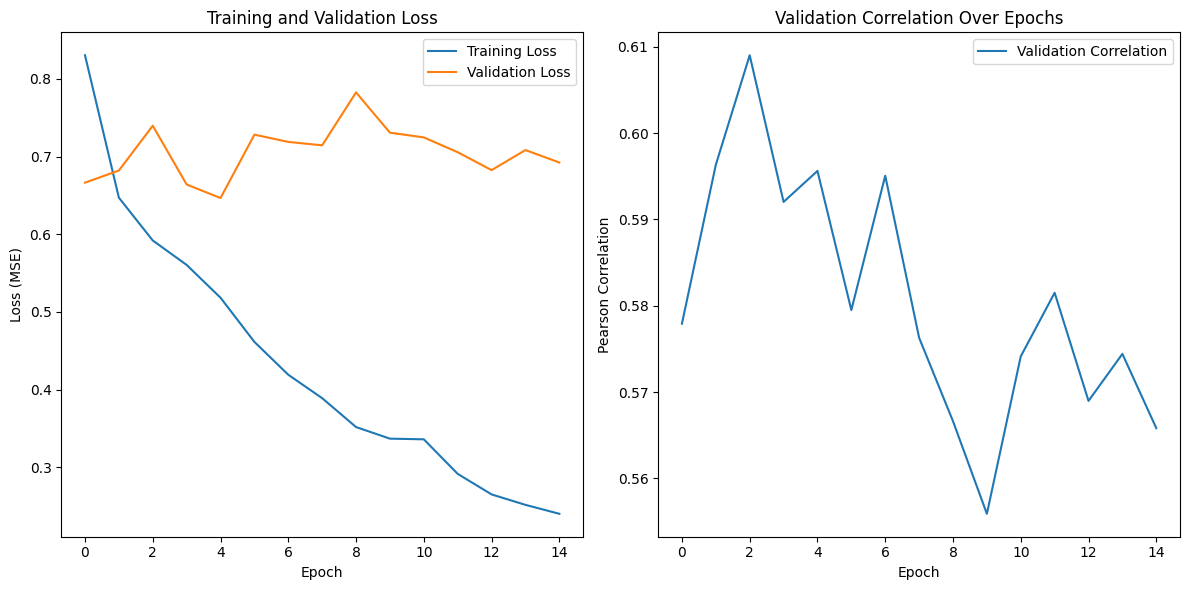

<ipython-input-16-c62fb9ca65bf>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(results_dir, "best_gnn_model.pt")))


Evaluating model...
Global Metrics (Normalized):
Pearson Correlation: 0.6062
RMSE: 0.7940
MAE: 0.5727
R^2 Score: 0.3674

Global Metrics (Original Scale):
Pearson Correlation: 0.1754
RMSE: 18.1463
MAE: 13.5422
R^2 Score: -0.3103


<ipython-input-17-11f00988ce40>:80: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_protein, _ = pearsonr(target, pred)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)



Average per-protein correlation: 0.6148
Median per-protein correlation: 0.6293
Number of proteins with correlation > 0.7: 71
Number of proteins with correlation > 0.8: 15


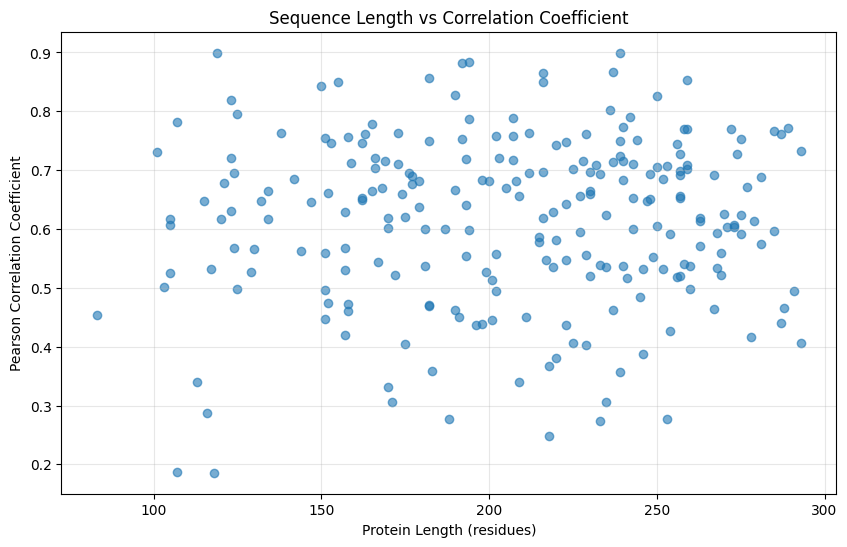

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


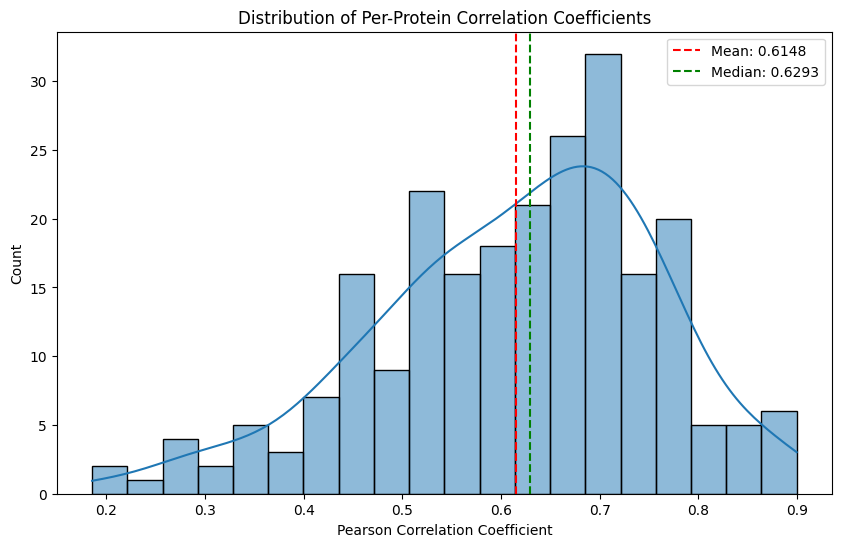

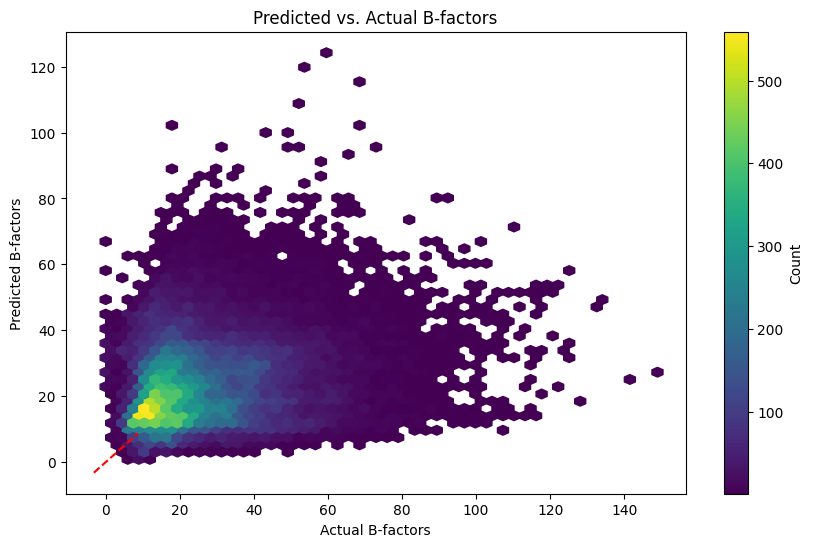

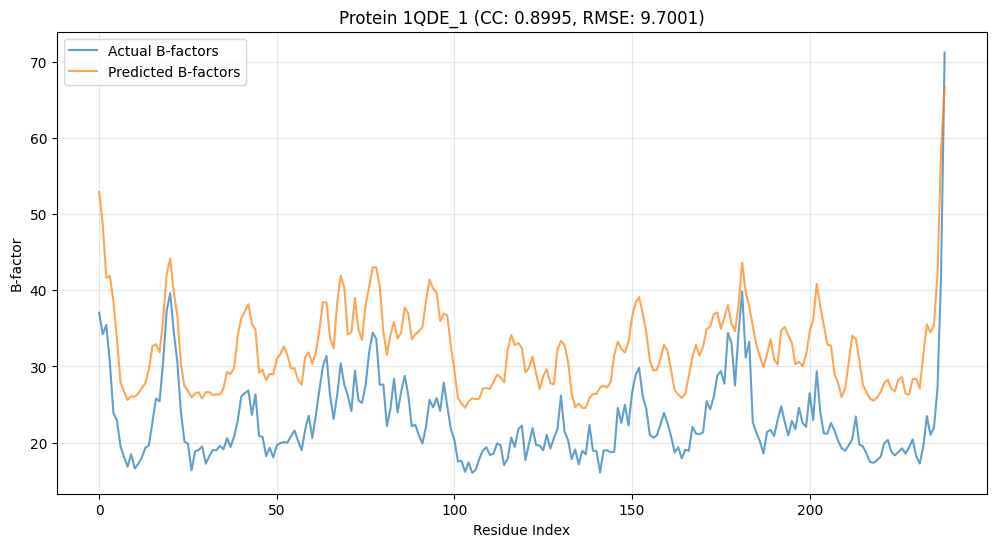

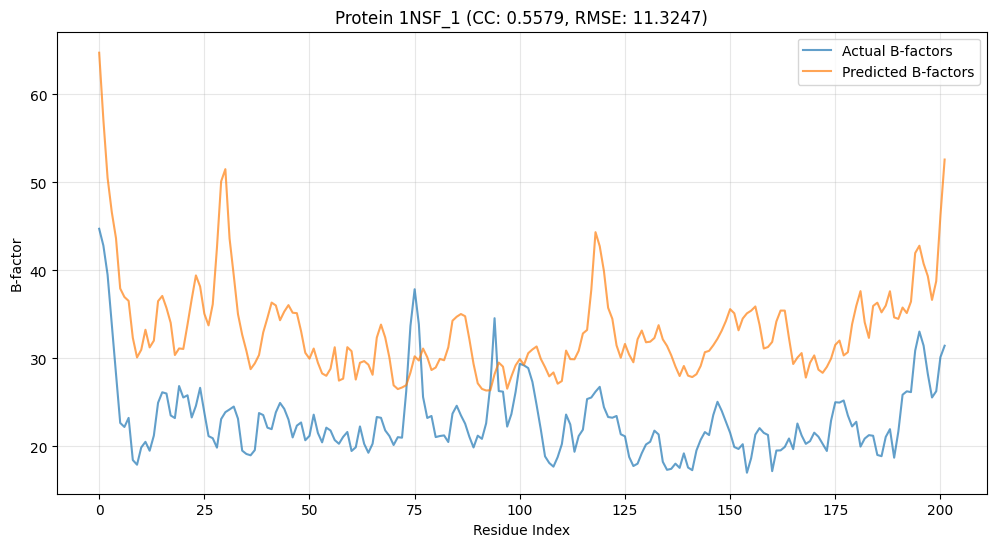

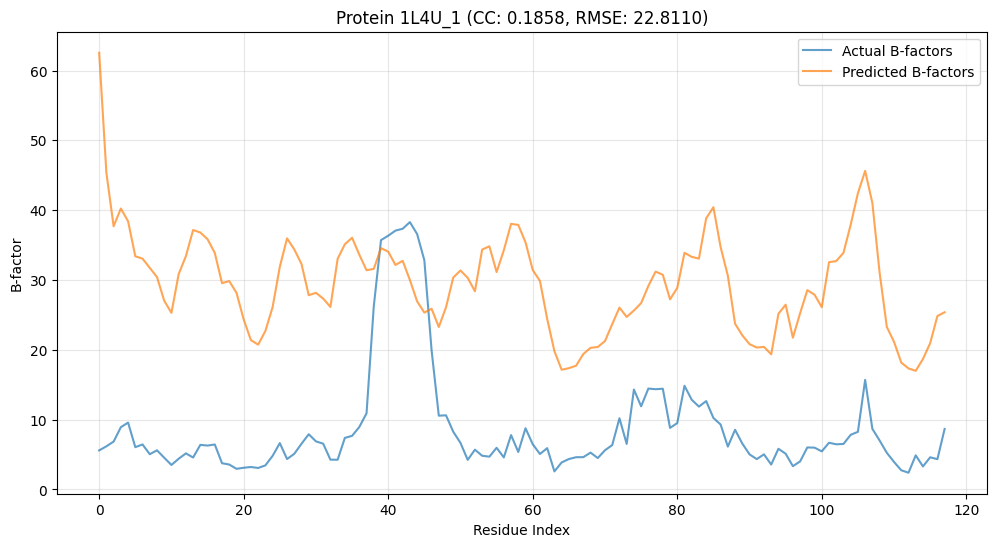

Visualizing predictions...


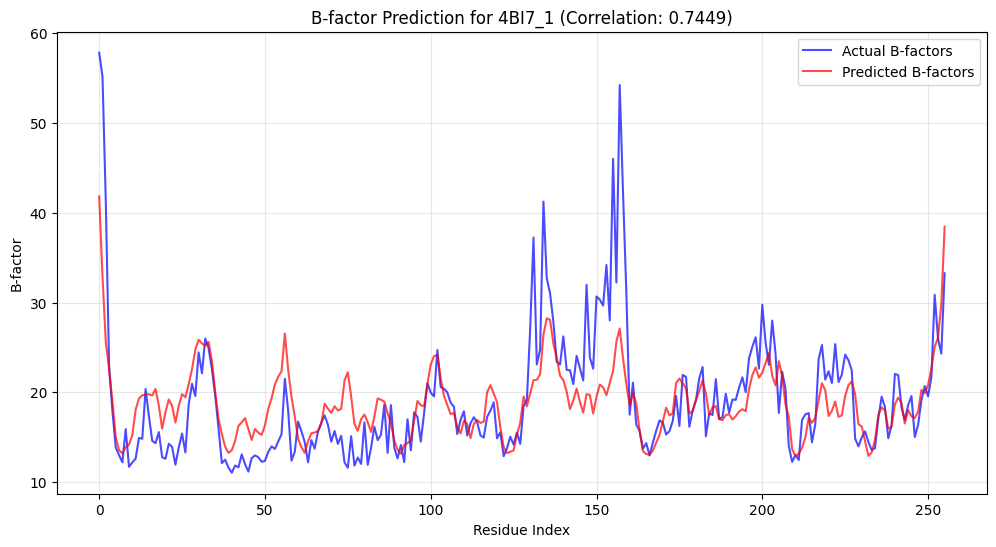

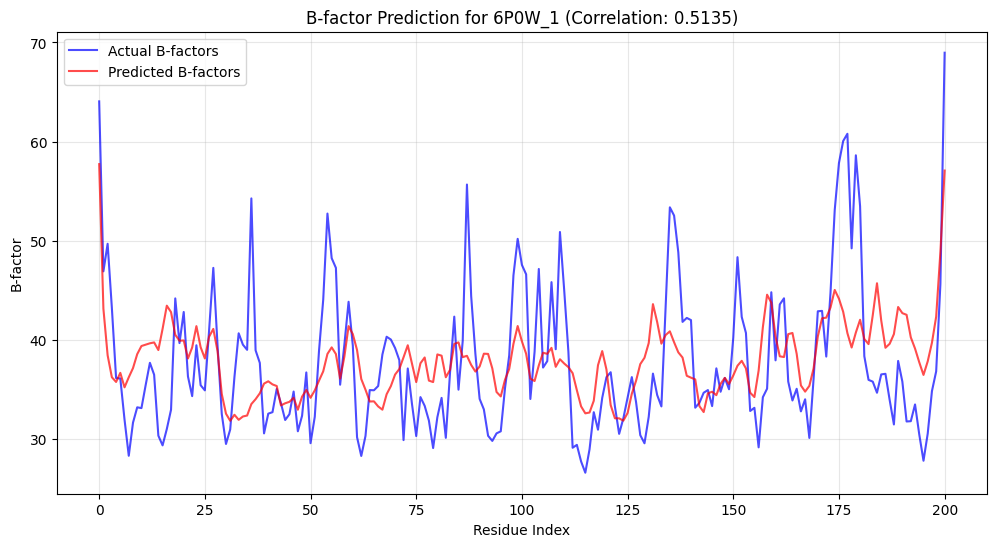

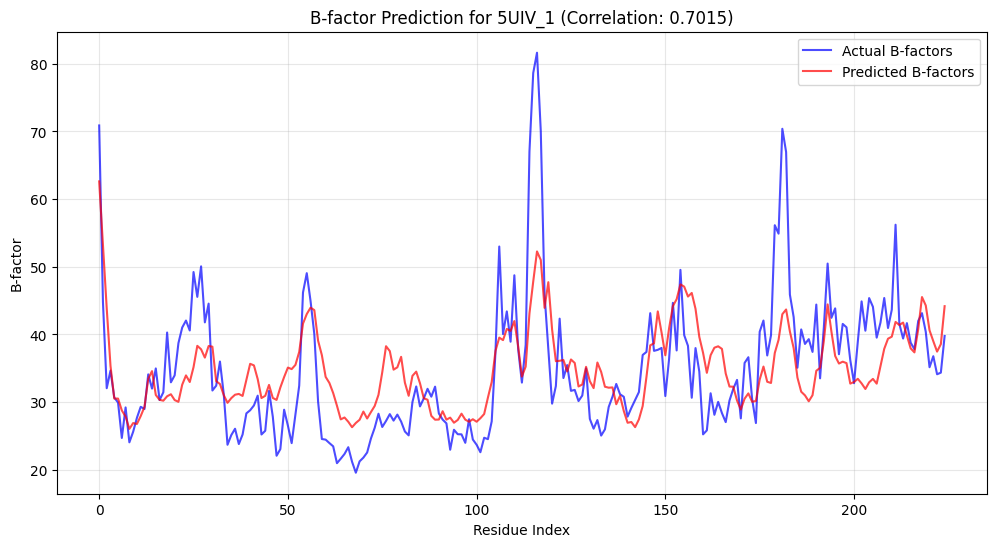

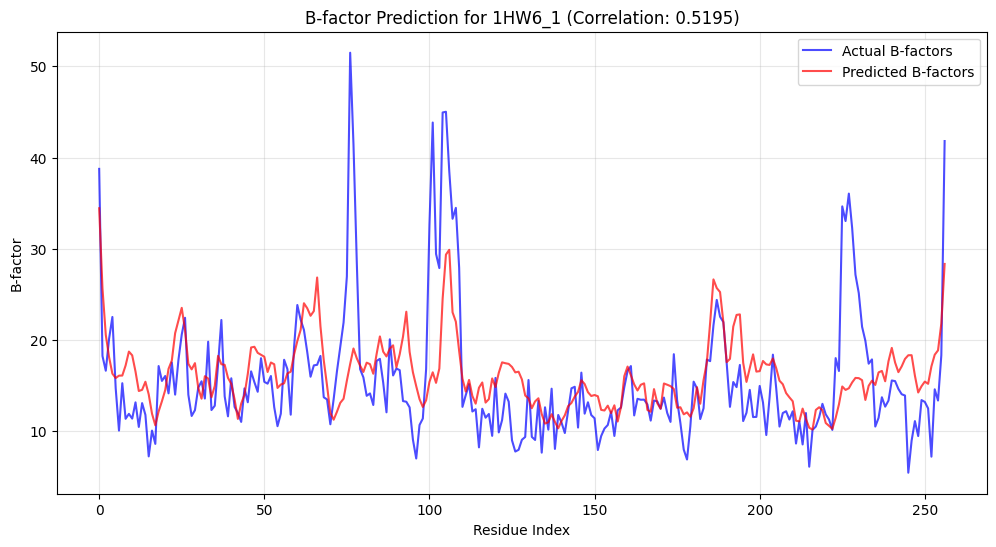

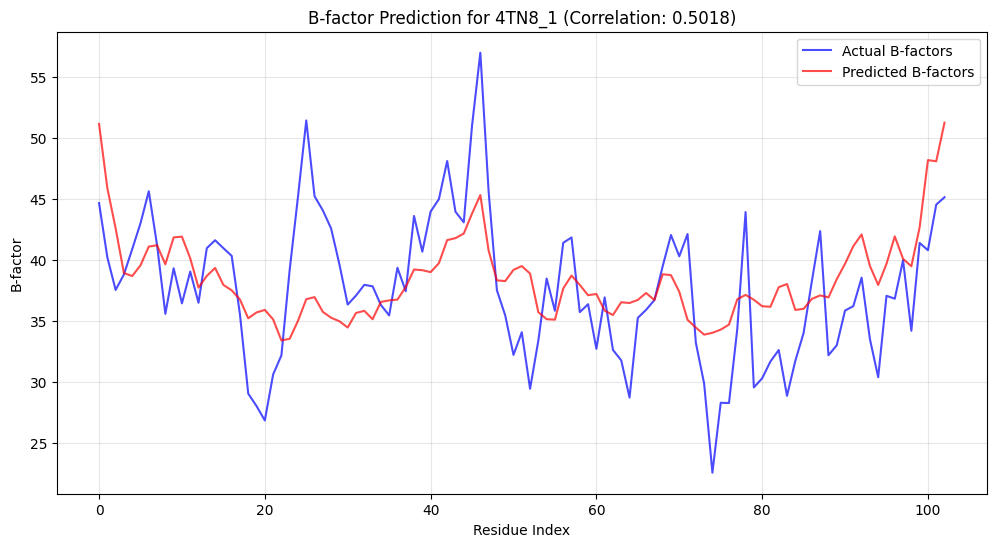

In [19]:
def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 1. Parse FASTA file
    print("Parsing FASTA file...")
    protein_df = parse_fasta(fasta_file)
    print(f"Found {len(protein_df)} protein sequences")
    
    # Take a subset if needed (for faster experimentation)
    SAMPLE_SIZE = 1192  # Adjust based on computational resources
    if len(protein_df) > SAMPLE_SIZE:
        protein_df = protein_df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
        print(f"Sampled {SAMPLE_SIZE} proteins for analysis")
    
    # 2. Download PDB files (show progress)
    print("Downloading PDB files...")
    for idx, row in tqdm(protein_df.iterrows(), total=len(protein_df)):
        pdb_id = row["PDB_ID"]
        download_pdb(pdb_id, pdb_dir)
    
    # 3. Load ESM model for sequence embeddings
    print("Loading language model for protein sequences...")
    esm_model, tokenizer = load_esm_model()
    
    # 4. Create protein graph dataset
    print("Creating protein graph dataset...")
    protein_dataset = ProteinGraphDataset(protein_df, pdb_dir, esm_model, tokenizer)
    print(f"Successfully processed {len(protein_dataset)} proteins")
    
    # Save processed proteins list
    processed_proteins = [protein_dataset.get_protein_id(i) for i in range(len(protein_dataset))]
    with open(os.path.join(results_dir, "processed_proteins.txt"), "w") as f:
        for protein in processed_proteins:
            f.write(f"{protein}\n")
    
    # 5. Split dataset
    indices = list(range(len(protein_dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)
    
    # Create data loaders
    train_loader = [protein_dataset[i] for i in train_idx]
    val_loader = [protein_dataset[i] for i in val_idx]
    test_loader = [protein_dataset[i] for i in test_idx]
    
    # Ensure collate_fn is defined before using it
    train_loader = PyGDataLoader(train_loader, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader = PyGDataLoader(val_loader, batch_size=8, shuffle=False, collate_fn=collate_fn)
    test_loader = PyGDataLoader(test_loader, batch_size=1, shuffle=False)  # Batch size 1 for per-protein analysis
    
    print(f"Train/Val/Test split: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")
    
    # 6. Initialize model
    sample_data = next(iter(train_loader))
    input_dim = sample_data.x.size(1)
    edge_dim = sample_data.edge_attr.size(1) if hasattr(sample_data, 'edge_attr') else 0
    
    print(f"Input dimension: {input_dim}, Edge dimension: {edge_dim}")
    model = ImprovedGNN_BFactorPredictor(
        input_dim=input_dim,
        edge_dim=edge_dim,
        hidden_dim=256,
        output_dim=1,
        num_layers=4,
        dropout=0.2
    )
    
    # Print model summary
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    
    # 7. Train model
    print("Training model...")
    model = train_gnn(model, train_loader, val_loader, device, epochs=100, lr=0.0005, patience=10)
    
    # 8. Evaluate model
    print("Evaluating model...")
    evaluate_gnn(model, test_loader, protein_dataset, device)
    
    # 9. Visualize predictions
    print("Visualizing predictions...")
    visualize_protein_predictions(model, test_loader, protein_dataset, device)

# Run the main function if executed as script
if __name__ == "__main__":
    main()